# US electricity consumption and production analysis

The United States has seen consistent growth in electricity production and consumption for decades. In the digital age, where many things are being moved to utilize electricity, the need for more capacity will soon be in high demand. Not only the power plants that generate it but also the means of transmission that move electricity to factories, schools, and homes. The goal of this project is to give a descriptive analysis of the current state of electricity production and forecast where electricity production will be in the future. Data like this is vital to utility companies, financial markets, energy developers, and every industry that feeds into the infrastructure of the United States electricity grid.

## Get the data

In [518]:
# Standard Data Science Libraries
import pandas as pd
import numpy as np

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Time Series Analysis Libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams

# Miscellaneous Libraries
import requests
import zipfile
import io
import os
import warnings

# Additional Libraries for Styling and Output
from colorama import Fore, Style
import statsmodels.api as sm

# Plot Style Configuration
plt.style.use('ggplot')


Notes:

Net generation excludes electricity use for power plant operations.
Terawatt hours, abbreviated as TWh, is a unit of energy representing one trillion watt hours.

Important links

[Electricity generation, capacity, and sales in the United States
](https://www.eia.gov/energyexplained/electricity/electricity-in-the-us-generation-capacity-and-sales.php#:~:text=In%202022%2C%20net%20generation%20of,solar%20photovoltaic%20(PV)%20systems.)

[Electricity data browser
](https://www.eia.gov/electricity/data.php)


#### Run the following packages to get Data

Power generation data

In [519]:
from EIA_DATA.generation_data import get_generation_data

In [520]:
raw_gneration_df = get_generation_data()

Power Plant data

This data fell outside the scope of the project so it is commented out.

In [521]:
#from EIA_DATA.plant_data import get_plant_data

In [522]:
#raw_plant_df = get_plant_data()

## Clean the data

### First the generation data

When we retrieved the data from the Excel file, it included rows above the headers. We can identify all values in the 'YEAR' column and remove them from the dataframe. Additionally, we can eliminate rows that contain NaN values. To ensure data integrity, we should check for duplicate rows as well.

In [523]:
invalid_rows = raw_gneration_df[raw_gneration_df['YEAR'].str.isnumeric() == False]
gen_df = raw_gneration_df.drop(invalid_rows.index).dropna()
gen_df.duplicated().sum()

0

To ensure we didn't have change our data too much we check the shape of the dataframe before and after.

In [524]:
print("Shape of raw_df:")
print(raw_gneration_df.shape)

print("\nShape of df:")
print(gen_df.shape)

removed_rows = raw_gneration_df.shape[0] - gen_df.shape[0]
print(f'We removed {removed_rows} row(s).')

Shape of raw_df:
(530838, 6)

Shape of df:
(530790, 6)
We removed 48 row(s).


We can change the date types to make our data easier to work with. Then check what they are after we have changed them.

In [525]:
gen_df = gen_df.infer_objects()
gen_df.dtypes


YEAR                            int64
MONTH                           int64
STATE                          object
TYPE OF PRODUCER               object
ENERGY SOURCE                  object
GENERATION (Megawatthours)    float64
dtype: object

We want to take the year and month columns and convert them into a date colum we can use to index the dataframe. We dont have a day of the month so we just use a constant value of 1. We can not get rid of the year and month columns to clean up the dataframe. We also want to infer objects again because we changed the headers and added a datetime column.

In [526]:
gen_df['DATE'] = pd.to_datetime(gen_df[['YEAR', 'MONTH']].assign(day=1),errors='coerce')
gen_df.set_index('DATE', inplace=True)
gen_df.drop(['YEAR', 'MONTH'], axis=1, inplace=True)
gen_df.head()

gen_df = gen_df.infer_objects()
gen_df.dtypes


STATE                          object
TYPE OF PRODUCER               object
ENERGY SOURCE                  object
GENERATION (Megawatthours)    float64
dtype: object

Converting the 'STATE' column to uppercase ensures a consistent and standardized representation of state names.

In [527]:
gen_df['STATE'] = gen_df['STATE'].str.upper()

The unit Megawatt-hours (MWh) is very small when dealing with net generation so we will reduce it to make it more manageable. We are going to use a Terawatt-hour (TWh) which is equal to 1 million Megawatt-hours. For reference the average house hold uses 10,632 kilowatt-hours per year or .00001063 TWh.

In [528]:
gen_df["Generation (TWh)"] = gen_df["GENERATION (Megawatthours)"]/1000000
gen_df.drop(['GENERATION (Megawatthours)'], axis=1, inplace=True)

### Make some copies of the data

Now that we have our data cleaned we will make a copy of the data frame to hold entegrity of the data

In [529]:
raw_df_copy = gen_df.copy()
raw_df_copy.shape

(530790, 4)

We will also make the df into a csv if we need to pull into excel to better understand

# Start of analysis

### Getting to know the data

We need to know more about the gen_df DataFrame to start

To better understand our data we can get all they types of producers and the types of energy sources by using the .unique() method. This will also help us validate that we cleaned the data correctly. 

In [530]:
types_producer = gen_df['TYPE OF PRODUCER'].unique()
types_producer

array(['Total Electric Power Industry',
       'Electric Generators, Electric Utilities',
       'Combined Heat and Power, Electric Power',
       'Combined Heat and Power, Commercial Power',
       'Combined Heat and Power, Industrial Power',
       'Electric Generators, Independent Power Producers'], dtype=object)

In [531]:
gen_df['ENERGY SOURCE'].unique()

array(['Coal', 'Petroleum', 'Natural Gas', 'Hydroelectric Conventional',
       'Wind', 'Total', 'Other Gases', 'Nuclear',
       'Wood and Wood Derived Fuels', 'Other Biomass', 'Other',
       'Solar Thermal and Photovoltaic', 'Pumped Storage', 'Geothermal'],
      dtype=object)

We can check on 'GENERATION (Twh)' column and get some statistics that will describe our dataset. 

In [532]:
gen_df['Generation (TWh)'].describe()

count    530790.000000
mean          1.390318
std          10.785769
min          -0.997855
25%           0.001574
50%           0.022916
75%           0.277950
max         425.611328
Name: Generation (TWh), dtype: float64

We see that our standard diviation is very high and there is a large gap between the percentiles. This tell us that there is many outliers and values that are zero. Anohter thing to note is that the min value is a negitive number. This is data on the generaion of electiricy so we went to know why type of energy source is pulling power instead of producing it. 

We can plot a histogram to see how the data is distributed and get a visual representation. 

<Axes: >

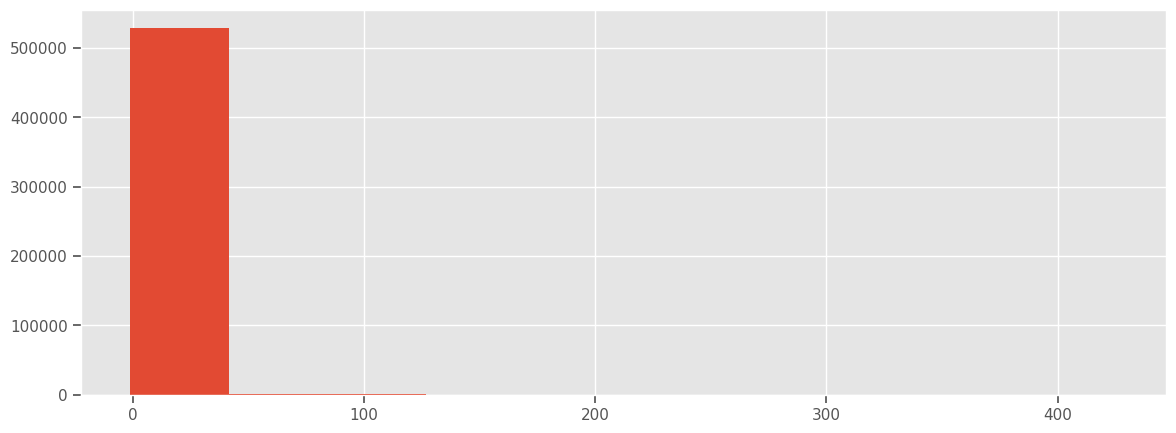

In [533]:
gen_df['Generation (TWh)'].hist()
#come back and add label and a title


The visual representation validates our observations from the describe() table, indicating a concentration of values around zero and notable outliers at the upper end. However, it's important to note that this graph represents a broad overview, encompassing diverse sources, states, and their totals spanning from 2001 to 2023. To narrow our focus and derive more targeted insights, we plan to apply filters, selecting specific subsets of data such as totals, specific sources, or particular states for further analysis.

In [534]:
gen_df['TYPE OF PRODUCER'].value_counts()


TYPE OF PRODUCER
Total Electric Power Industry                       143564
Electric Generators, Electric Utilities             100222
Electric Generators, Independent Power Producers     95985
Combined Heat and Power, Industrial Power            82955
Combined Heat and Power, Commercial Power            58112
Combined Heat and Power, Electric Power              49952
Name: count, dtype: int64

We can see there are really three categories in the producer columns. 
- Electric Generators
- Combined Heat and Power
- Total Electric Power Industry

Each have a subcategory too.

We can now do the same for the plant_df DataFrame

# EDA

## Total US power generation by month

#### Understanding the Total electric power generation

We will start our analysis on the 'Total Electric Power Industry' to begin

Totals are already calculated in the df so we will just need to pull the right columns.

In [535]:
total=gen_df.loc[gen_df['TYPE OF PRODUCER']=='Total Electric Power Industry']
US_total=total.loc[total['STATE']=='US-TOTAL']
US_source=US_total.groupby(by=[US_total.index,"ENERGY SOURCE"]).sum().reset_index()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


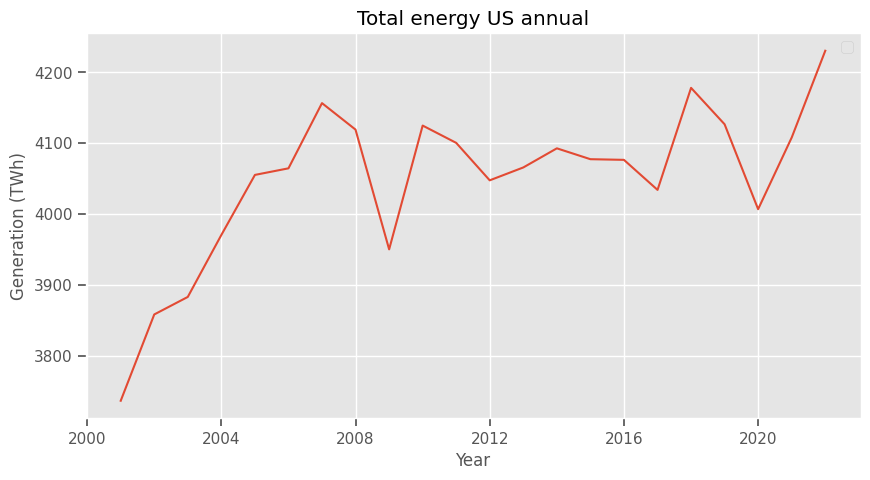

In [536]:
US_total_month=US_source[(US_source['ENERGY SOURCE']=='Total')]

US_total_year = US_total_month.groupby(US_total_month['DATE'].dt.year, as_index=False).agg({'DATE': 'first', 'Generation (TWh)': 'sum'})

US_total_year = US_total_year[US_total_year['DATE'].dt.year != 2023]

plt.figure(figsize=(10,5))
sns.color_palette("tab10")
sns.lineplot(data=US_total_year, x=US_total_year['DATE'] \
             ,y=US_total_year['Generation (TWh)'])
plt.title("Total energy US annual")
plt.xlabel("Year")
plt.legend(loc='best')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


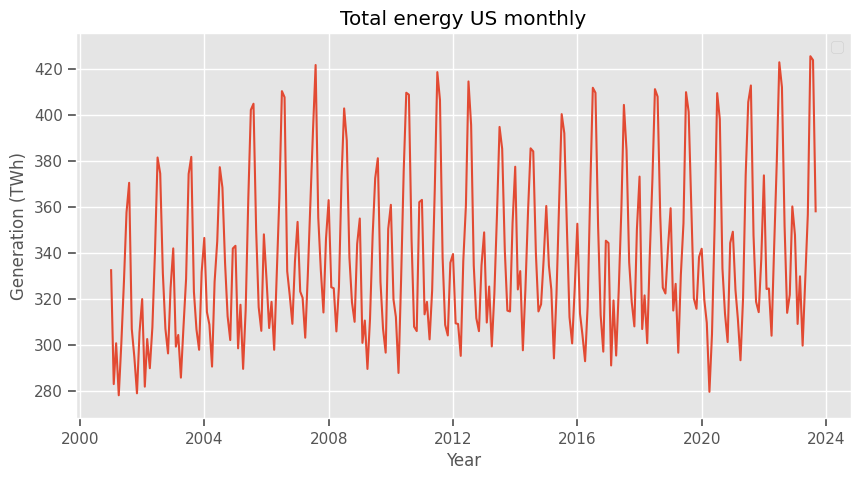

In [537]:
US_total_month=US_source[(US_source['ENERGY SOURCE']=='Total')]

plt.figure(figsize=(10,5))
sns.color_palette("tab10")
sns.lineplot(data=US_total_month, x=US_total_month['DATE'] \
             ,y=US_total_month['Generation (TWh)'])
plt.ylim(US_total_month['Generation (TWh)'].min() - 10, US_total_month['Generation (TWh)'].max() + 10) 
plt.title("Total energy US monthly")
plt.xlabel("Year")
plt.legend(loc='best')
plt.show()

We can see there is a lot of noise in the data. Energy production is very seasonal.

## Energy Production by state

Now that we have looked at the totals we want to look net generation by state. So we dont double count any values we will make a DataFrame that is the inverse of the totals DataFrame by taking out all of the US-Total values. 

Similar to how we separated the totals from the rest of the data we will pull totals out so we dont double count when we group by states

In [538]:
state_df = gen_df[(gen_df['STATE'] != 'US-TOTAL') & 
              (gen_df['TYPE OF PRODUCER'] != 'Total Electric Power Industry') & 
              (gen_df['ENERGY SOURCE'] == 'Total')]

Make some more DataFrames by grouping by states: month year and all-time

In [539]:
state_total_month =state_df.groupby(by=[state_df.index,"STATE"]).sum().reset_index()
state_total_year =state_df.groupby(by=[state_df.index.year,"STATE"]).sum().reset_index()
state_total_alltime =state_df.groupby(by=["STATE"]).sum().reset_index().sort_values(by='Generation (TWh)')
state_total_alltime.shape

(51, 4)

By sorting the values we can see the state that has produced the most electricity in the last 22 years cumulative.

In [540]:
TimePeriodOfData = (state_df.index.year.unique().max()) - (state_df.index.year.unique().min())
TimePeriodOfData

22

In [541]:
state_total_month_top10=state_total_alltime[['STATE','Generation (TWh)']].sort_values(by='Generation (TWh)', ascending=False).iloc[:10]
state_total_month_top10[['STATE','Generation (TWh)']]

,STATE,Generation (TWh)
43,TX,9894.888992
9,FL,5218.290742
38,PA,5036.201059
4,CA,4568.488753
14,IL,4341.616358
1,AL,3261.197689
35,OH,3109.237906
34,NY,3088.521236
10,GA,2930.871739
27,NC,2882.807861


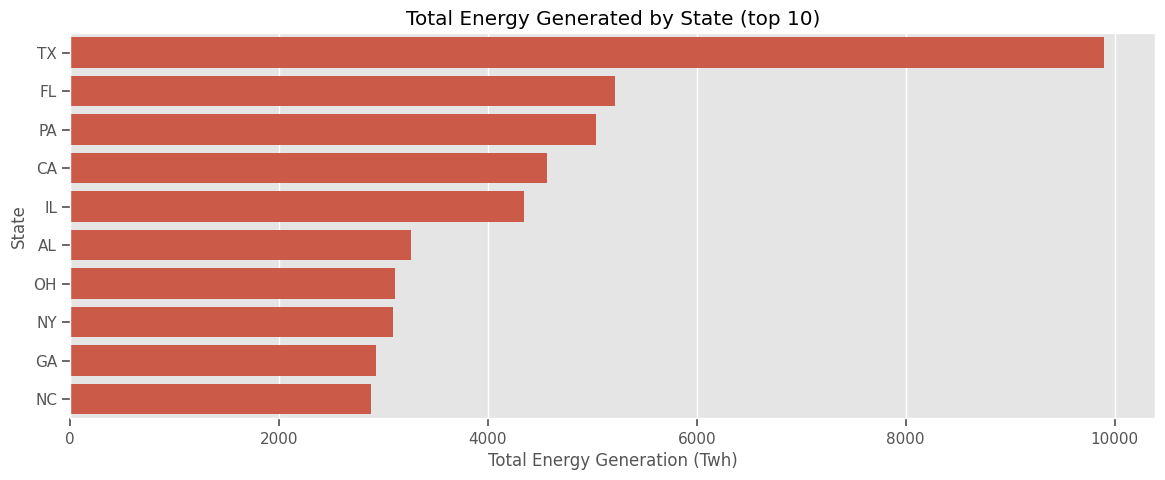

In [542]:
state_total_alltime['AVG Generation'] = state_total_alltime['Generation (TWh)']/TimePeriodOfData
state_total_alltime['Percent of total US generation'] = (state_total_alltime['Generation (TWh)']/state_total_alltime['Generation (TWh)'].sum())
state_total_alltime['Percent of total US generation'] = (state_total_alltime['Percent of total US generation'] * 100).map("{:.2f}%".format)


state_total_alltime[['STATE','Generation (TWh)','AVG Generation','Percent of total US generation']].sort_values(by= 'Generation (TWh)',ascending = False).head(5)

sns.barplot(x='Generation (TWh)', y='STATE', data=state_total_month_top10,errorbar=None)
sns.color_palette("tab10")
plt.xlabel('Total Energy Generation (Twh)')
plt.ylabel('State')
plt.title('Total Energy Generated by State (top 10)')

plt.show()

Might want to add per capita data and graph it againt the total generation. 

## Energy Sources

Now we will look into the sources that we get electicity from.

In [543]:
US_source_no_total=US_source[(US_source['ENERGY SOURCE']!='Total')]
US_source_no_total[['DATE','ENERGY SOURCE','Generation (TWh)']].sort_values(by = 'Generation (TWh)', ascending= False).head()

,DATE,ENERGY SOURCE,Generation (TWh)
3783,2023-07-01,Natural Gas,200.506759
3797,2023-08-01,Natural Gas,199.993042
1106,2007-08-01,Coal,190.134816
938,2006-08-01,Coal,189.454930
3615,2022-07-01,Natural Gas,189.042160


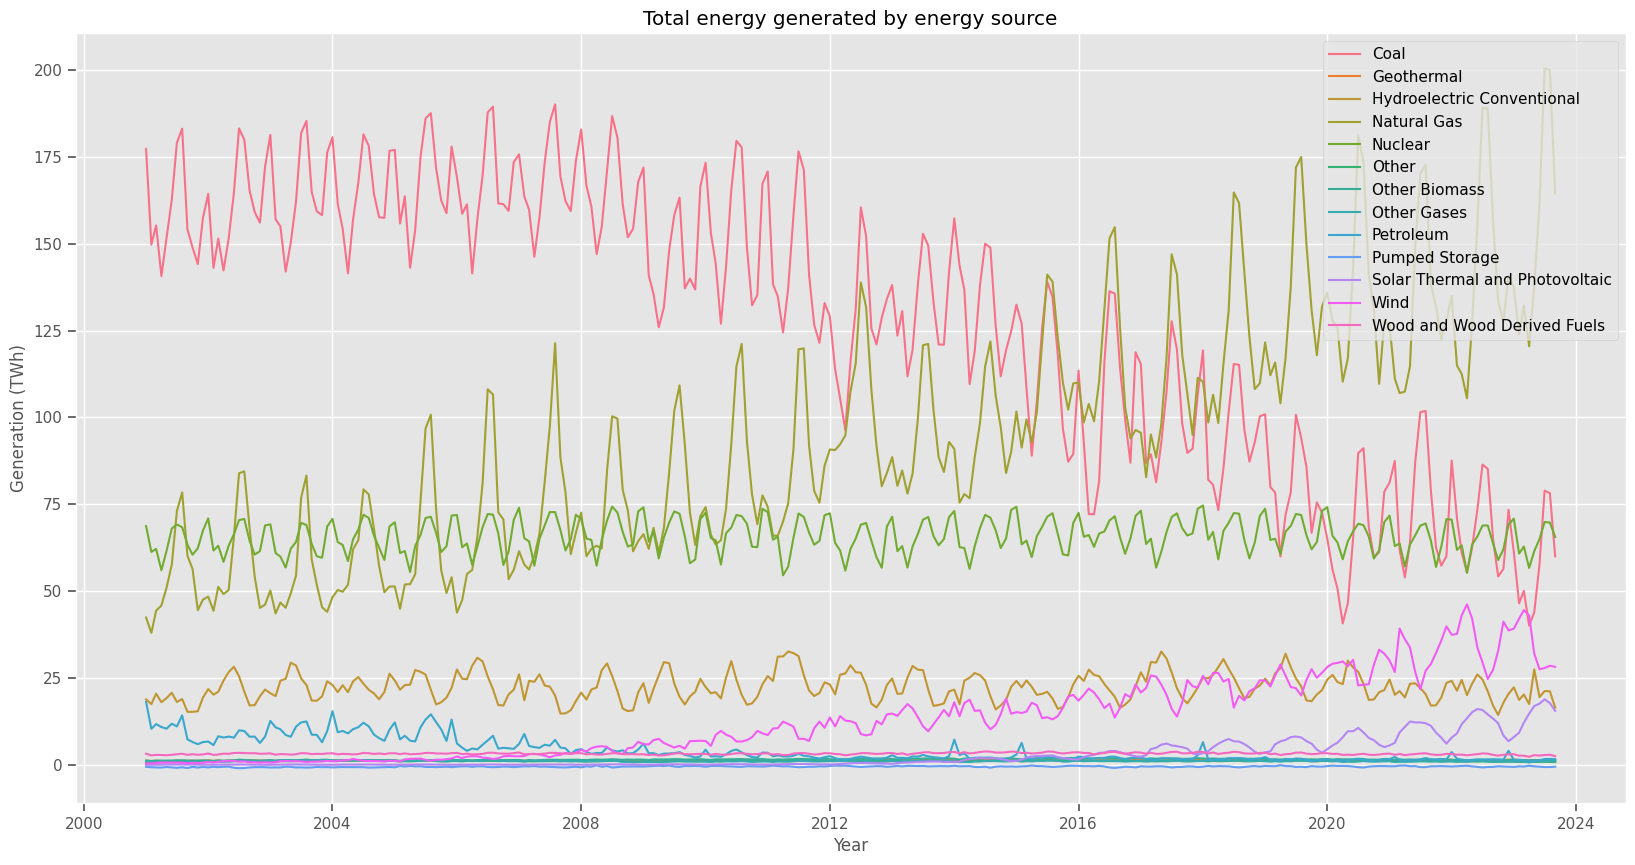

In [544]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_source_no_total, x=US_source_no_total['DATE'] \
             ,y=US_source_no_total['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by energy source")
plt.xlabel("Year")
plt.legend(loc='best')
plt.show()

This chart is very busy so we can break down the energy sources into three groups High Med and Small

In [545]:
top_3 = ['Coal' ,'Natural Gas', 'Nuclear'] 
US_top3=US_source[US_source['ENERGY SOURCE'].isin(top_3)]
US_top3.head()

,DATE,ENERGY SOURCE,STATE,TYPE OF PRODUCER,Generation (TWh)
0,2001-01-01,Coal,US-TOTAL,Total Electric Power Industry,177.287111
3,2001-01-01,Natural Gas,US-TOTAL,Total Electric Power Industry,42.388663
4,2001-01-01,Nuclear,US-TOTAL,Total Electric Power Industry,68.707077
14,2001-02-01,Coal,US-TOTAL,Total Electric Power Industry,149.735484
17,2001-02-01,Natural Gas,US-TOTAL,Total Electric Power Industry,37.966927


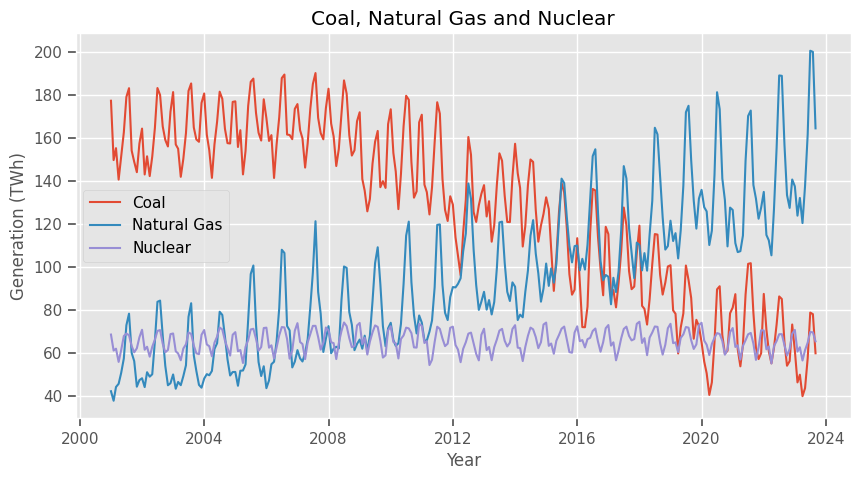

In [546]:
plt.figure(figsize=(10,5))
sns.color_palette("tab10")
sns.lineplot(data=US_top3, x=US_top3['DATE'] ,y=US_top3['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Coal, Natural Gas and Nuclear")
plt.xlabel("Year")
plt.legend(loc='best')

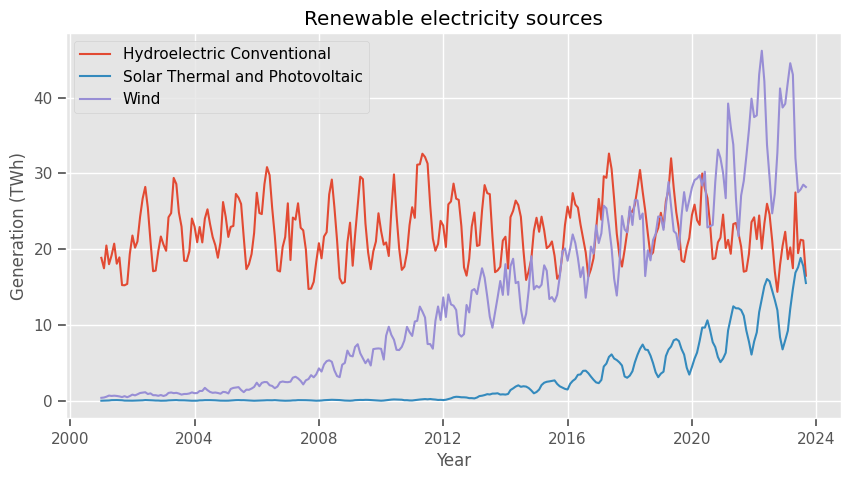

In [547]:
snd_4 = ['Wind' ,'Hydroelectric Conventional', 'Solar Thermal and Photovoltaic'] 
US_snd4=US_source[US_source['ENERGY SOURCE'].isin(snd_4)]

plt.figure(figsize=(10,5))
sns.color_palette("viridis")
sns.lineplot(data=US_snd4, x=US_snd4['DATE'] ,y=US_snd4['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Renewable electricity sources")
plt.xlabel("Year")
plt.legend(loc='best')

We can see here the growth in solar and wind energy in the past decade

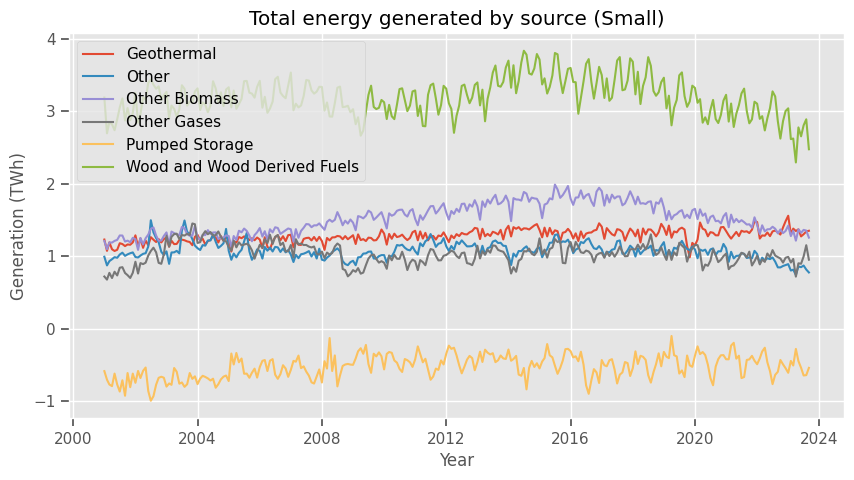

In [548]:
bottom=['Other','Other Gases','Pumped Storage','Wood and Wood Derived Fuels'\
        ,'Other Biomass','Geothermal']
US_bot=US_source[US_source['ENERGY SOURCE'].isin(bottom)]

plt.figure(figsize=(10,5))
sns.color_palette("deep")
sns.lineplot(data=US_bot, x=US_bot['DATE'] ,y=US_bot['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by source (Small)")
plt.xlabel("Year")
plt.legend(loc='upper left')

We can also look at look at the three that look to be growing the most, Natrual gas, wind, and solar.

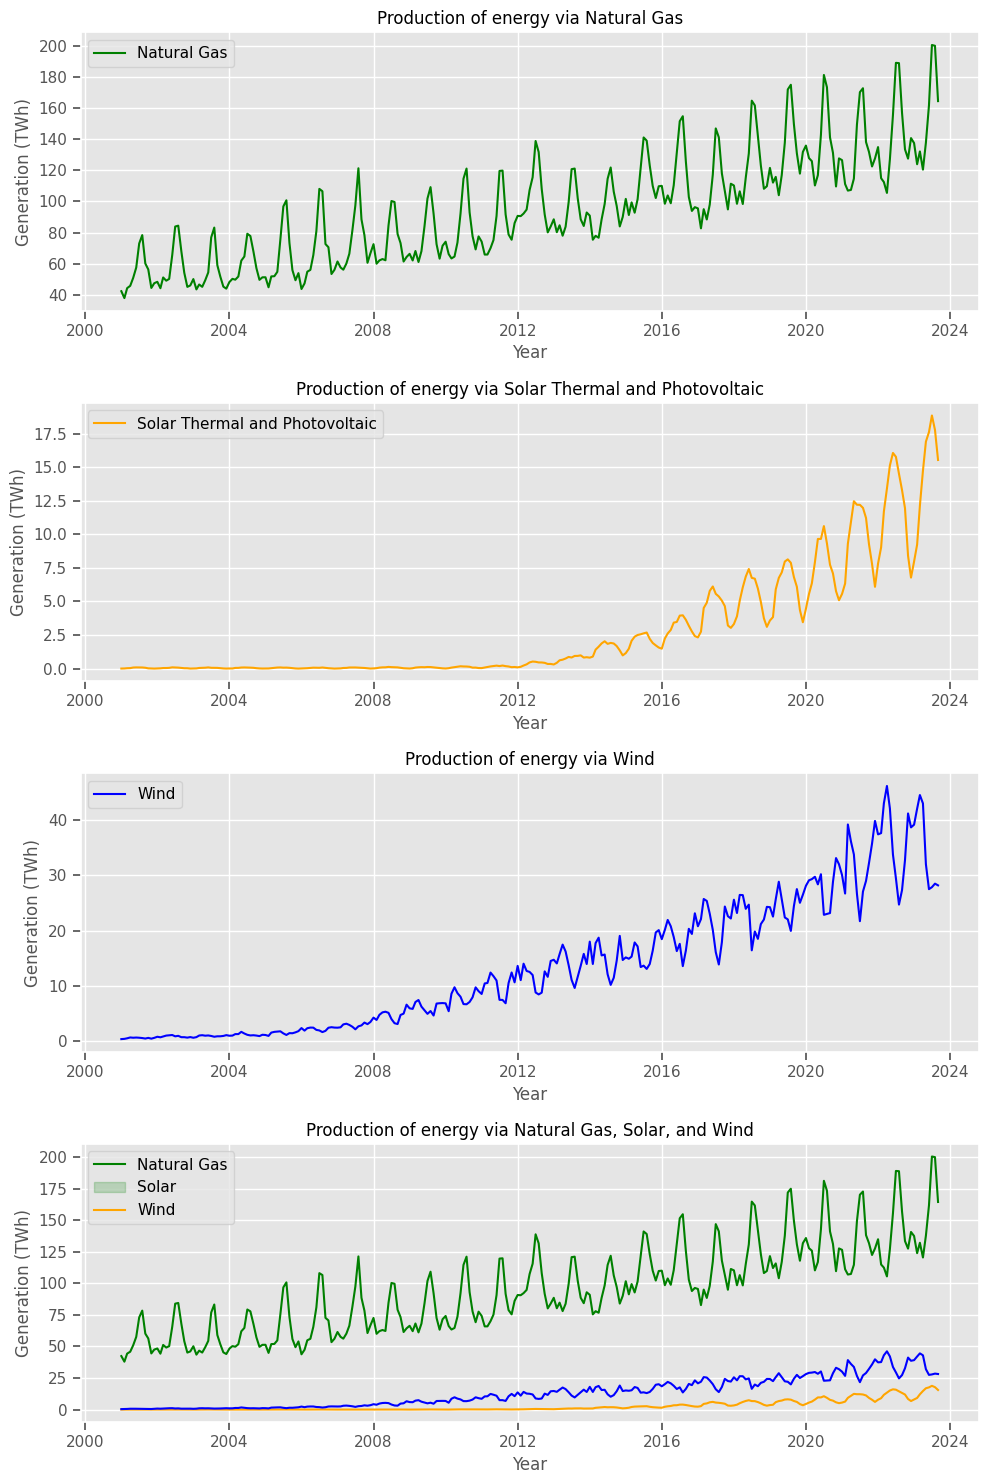

In [549]:
sns.set_context("notebook")
fig, axs = plt.subplots(4, 1, figsize=(10, 15))

def plot_energy_source(ax, df, energy_source, color):
    source_data = df.loc[df['ENERGY SOURCE'] == energy_source]
    sns.lineplot(x=source_data.index, y=source_data['Generation (TWh)'], color=color, ax=ax)
    ax.set_title(f'Production of energy via {energy_source}')
    ax.set_xlabel("Year")
    ax.set_ylabel("Generation (TWh)")
    ax.legend([energy_source]) 

plot_energy_source(axs[0], US_total, 'Natural Gas', 'green')
plot_energy_source(axs[1], US_total, 'Solar Thermal and Photovoltaic', 'orange')
plot_energy_source(axs[2], US_total, 'Wind', 'blue')
ax_combined = axs[3]

plot_energy_source(ax_combined, US_total, 'Natural Gas', 'green')
plot_energy_source(ax_combined, US_total, 'Solar Thermal and Photovoltaic', 'orange')
plot_energy_source(ax_combined, US_total, 'Wind', 'blue')

ax_combined.set_title('Production of energy via Natural Gas, Solar, and Wind')
ax_combined.set_xlabel("Year")

ax_combined.legend(['Natural Gas', 'Solar', 'Wind'])

plt.tight_layout()
plt.show()

Plotted by themselves they look to grow very fast but when ploted together solar and windthe make up of net generation 

# Modeling and Forcasting energy production

Now that we have a good understand anout the distribution of types of energy used to produce electricity we can dive into creating a model that will help us predict total energy production. It is important to remeber that energy is not the same thing as electricity. While electricity is energy, energy is not always electricity.

More data.

In [550]:
production_url = 'https://www.eia.gov/totalenergy/data/browser/csv.php?tbl=T01.02'
consumption_url = 'https://www.eia.gov/totalenergy/data/browser/csv.php?tbl=T01.03'
imports_url = 'https://www.eia.gov/totalenergy/data/browser/csv.php?tbl=T01.04A'
exports_url = 'https://www.eia.gov/totalenergy/data/browser/csv.php?tbl=T01.04B'
net_generation_url = 'https://www.eia.gov/totalenergy/data/browser/csv.php?tbl=T07.02A'

production = pd.read_csv(production_url)
consumption = pd.read_csv(consumption_url)
imports = pd.read_csv(imports_url)
exports = pd.read_csv(exports_url)
net_generation = pd.read_csv(net_generation_url)

In [551]:
net_generation_df = net_generation.pivot(index='YYYYMM', columns='Description', values='Value')
total_net_gen_df = net_generation_df.loc[:, ['Electricity Net Generation Total (including from sources not shown), All Sectors']]
production_df = production.pivot(index='YYYYMM', columns='Description', values='Value')
consumption_df = consumption.pivot(index='YYYYMM', columns='Description', values='Value')
imports_df = imports.pivot(index='YYYYMM', columns='Description', values='Value')
exports_df = exports.pivot(index='YYYYMM', columns='Description', values='Value')

In [552]:
merged_df = total_net_gen_df.merge(production_df, on='YYYYMM', how='left')
merged_df = merged_df.merge(consumption_df, on='YYYYMM', how='left')
merged_df = merged_df.merge(imports_df, on='YYYYMM', how='left')
df_train = merged_df.merge(exports_df, on='YYYYMM', how='left')
df_train = df_train.replace('Not Available',0)
df_train = df_train[(df_train.index % 100 == 13)]
df_train.shape

(74, 44)

We go data on production, consumption, imports, and exports. We might not use it all but it was easy to get.

### Ordinary least squares regression

We want to see the what types of energy production have good corolation with total electricity production. But are not produced as electricity to start. Natrural Gas, Coal, and Oil, are produced and turned into electricity so we will check for correlations. 

In [553]:
df_ols = pd.DataFrame({
    'Crude Oil Production': df_train['Crude Oil Production'],
    'Electricity Net Generation': df_train['Electricity Net Generation Total (including from sources not shown), All Sectors'],
    'Natural Gas Plant Liquids Production': df_train['Natural Gas Plant Liquids Production'],
    'Coal Production': df_train['Coal Production'],
    'Crude Oil Production': df_train['Crude Oil Production']})
df_ols = df_ols.astype(float)

df_ols.index = df_ols.index.astype(str).str[:4]


df_ols

,Crude Oil Production,Electricity Net Generation,Natural Gas Plant Liquids Production,Coal Production
YYYYMM,,,,
1949,10.683252,296124.289,0.706102,11.973882
1950,11.446729,334087.601,0.813366,14.060135
1951,13.036724,375298.355,0.910336,14.419325
1952,13.281049,403829.413,0.985701,12.734313
1953,13.671076,447048.563,1.050702,12.277746
...,...,...,...,...
2018,22.807907,4180987.703,5.726973,15.363442
2019,25.604215,4130573.880,6.351729,14.255763
2020,23.574988,4009766.846,6.804761,10.703214


In [554]:
x_ols = sm.add_constant(df_ols[['Crude Oil Production', 'Coal Production','Natural Gas Plant Liquids Production']])
y_ols = df_ols['Electricity Net Generation']

The OLS model or ordinary least squares regression is what we will use. 

In [555]:
ols_model =sm.OLS(y_ols,x_ols).fit()
print(ols_model.summary())

                                OLS Regression Results                                
Dep. Variable:     Electricity Net Generation   R-squared:                       0.970
Model:                                    OLS   Adj. R-squared:                  0.969
Method:                         Least Squares   F-statistic:                     754.1
Date:                        Wed, 20 Dec 2023   Prob (F-statistic):           3.38e-53
Time:                                17:31:26   Log-Likelihood:                -1019.1
No. Observations:                          74   AIC:                             2046.
Df Residuals:                              70   BIC:                             2055.
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

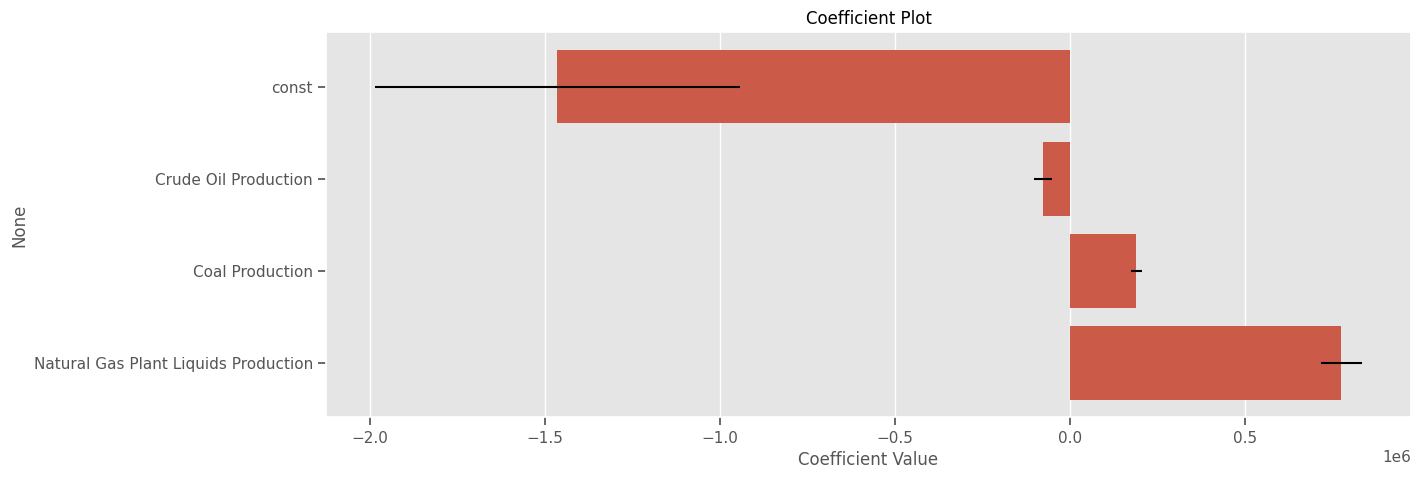

In [556]:
coef_data = ols_model.params
ci_data = ols_model.conf_int()

sns.barplot(x=coef_data, y=coef_data.index)
plt.errorbar(x=coef_data, y=coef_data.index, xerr=(coef_data - ci_data[0], ci_data[1] - coef_data), fmt='none', color='black')
plt.title('Coefficient Plot')
plt.xlabel('Coefficient Value')
plt.show()

Based on energy products that are not directly converted to electricity we can see Natural gas production has the highest corrolaiton with toal energy consumption. Other two dont exceed the constant. 

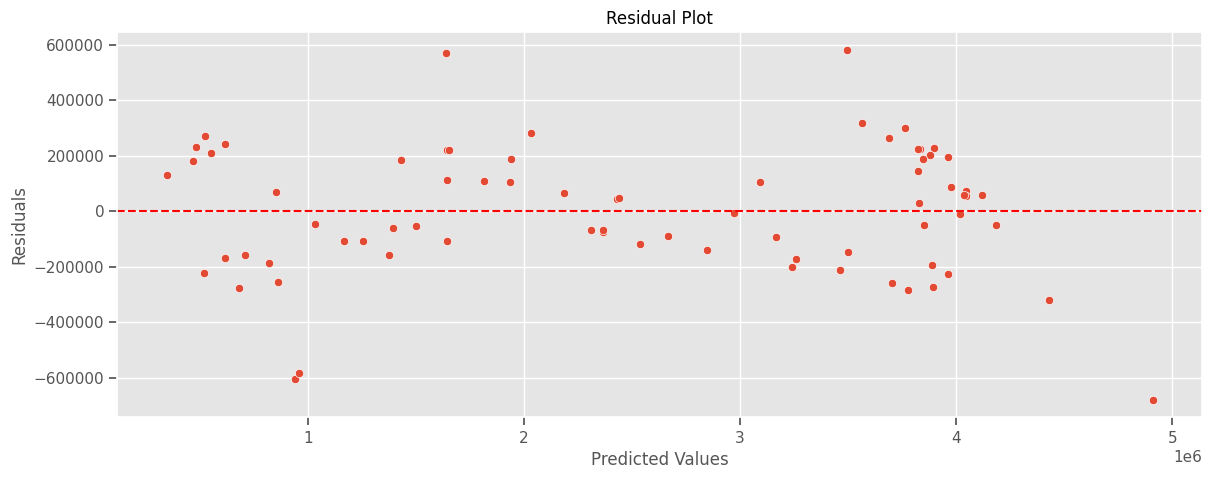

In [557]:
residuals = ols_model.resid

# Plot residuals against predicted values
sns.scatterplot(x=ols_model.fittedvalues, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

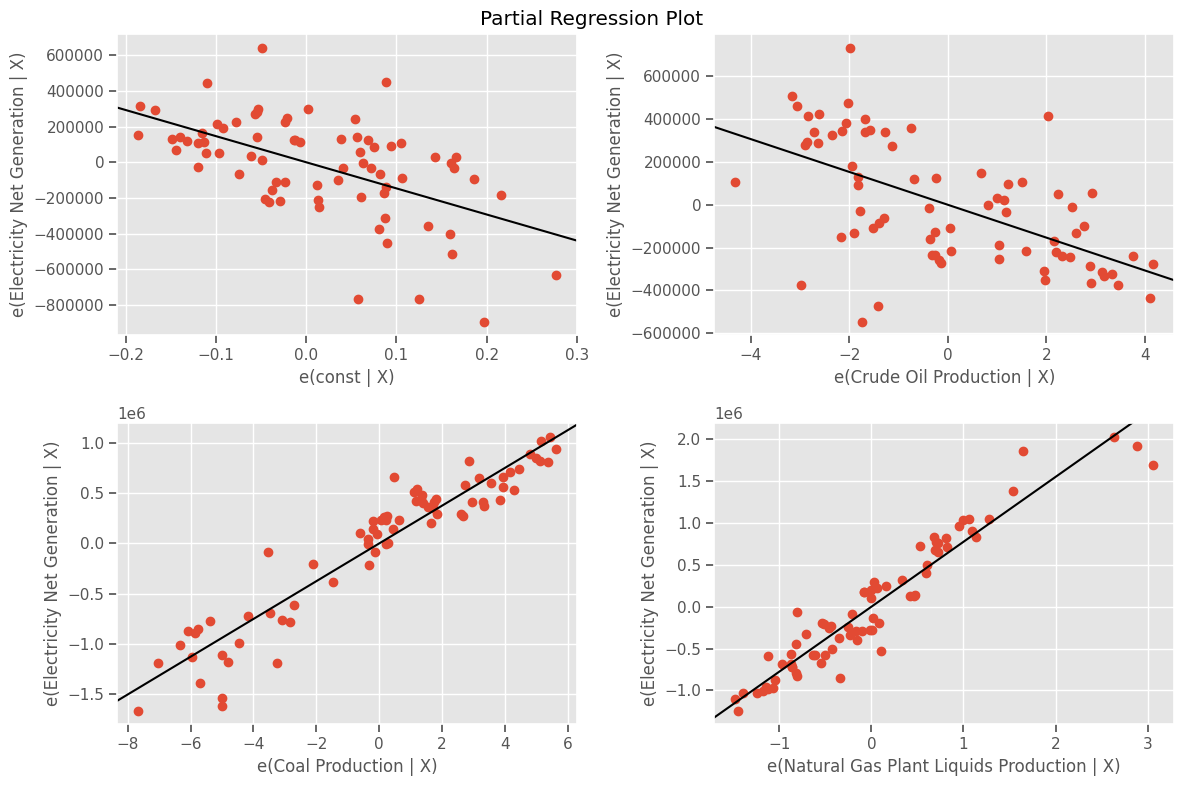

In [558]:
from statsmodels.graphics.regressionplots import plot_partregress_grid

fig = plt.figure(figsize=(12, 8))
plot_partregress_grid(ols_model, fig=fig)
plt.show()

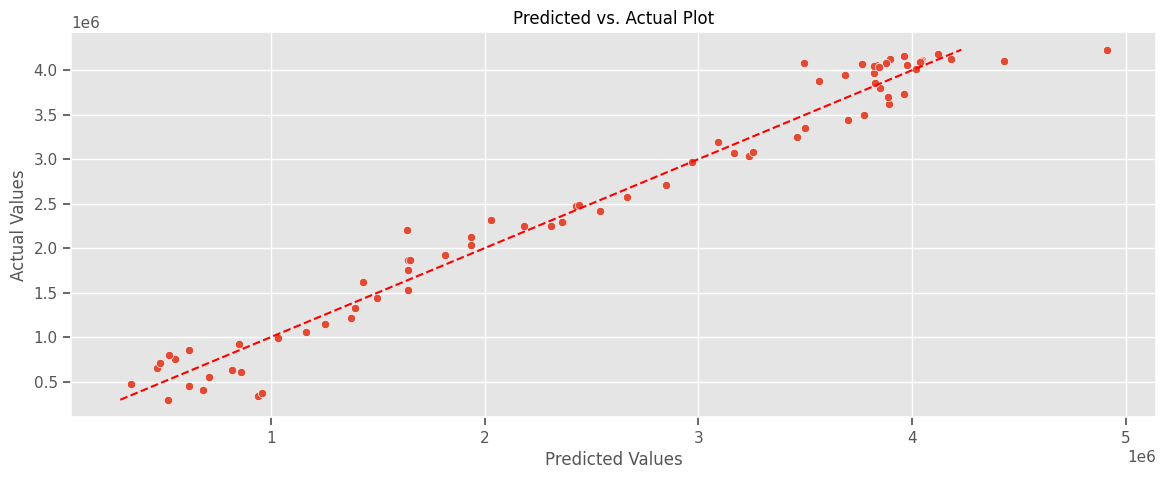

In [559]:
sns.scatterplot(x=ols_model.fittedvalues, y=y_ols)
plt.plot([y_ols.min(), y_ols.max()], [y_ols.min(), y_ols.max()], linestyle='--', color='red')
plt.title('Predicted vs. Actual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

Based on our model we see the predicted values resemle our actual values we did not show the model. 

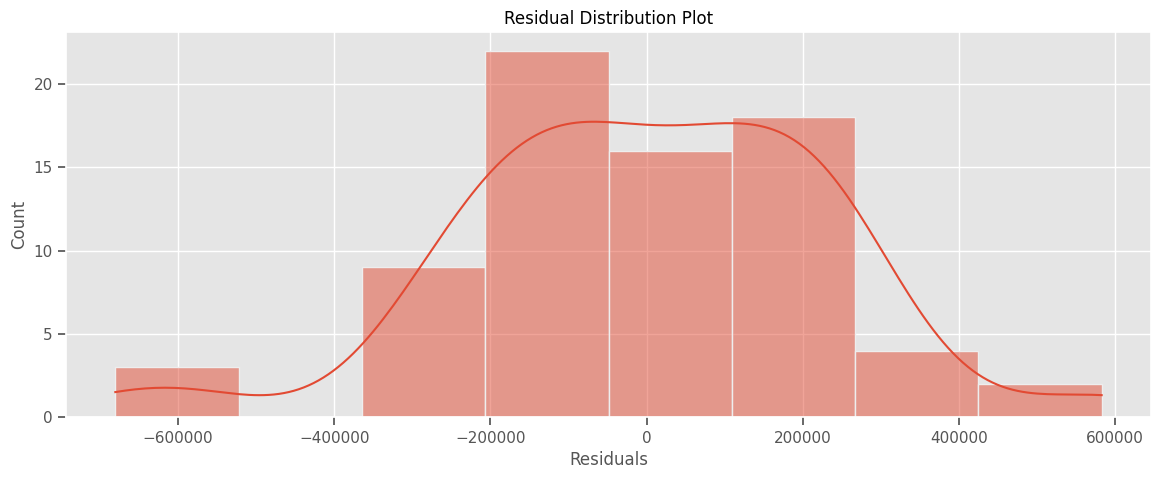

In [560]:
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution Plot')
plt.xlabel('Residuals')
plt.show()

From our analysis we can see Natural Gas has the highest coefficient. This makes sense and agrees with our analysis above. Natural Gas is the largest sources of energy for electric generation. 

### Gradient Boosting Regressor and Random Forest

#### Gradient Boosting Regressor

We want to use a model that will take in multiple features such as gradient boosing regression from sklearn. We know a little about the data but lets run it with all the features first to see what we will need to take out. This will require splitting the data so we can train on some and save some to test.

In [561]:
y_df = df_train['Electricity Net Generation Total (including from sources not shown), All Sectors']
drops = ['Electricity Net Generation Total (including from sources not shown), All Sectors']
x_df = df_train.drop(drops, axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size = 0.20, random_state = 0)


In [562]:
gbr = GradientBoostingRegressor(n_estimators = 500, random_state=42)
gbr.fit(x_train,y_train)

GradientBoostingRegressor(n_estimators=500, random_state=42)

In [563]:
y_pred = gbr.predict(x_test)
print(y_pred)

[3576903.81282921 3823737.48262721 1562080.90290608 3117683.75850883
 2063881.64857246 1852184.70484231 4061298.11300933 3693237.31840429
 2295135.42398597  583946.1440307  3015555.77485202 3994220.5710864
 2994921.1517094  4119470.08914786 2330577.51856912]


In [564]:
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print(f'MAE: {mae}, MSE: {mse}, R^2: {r2}')

MAE: 54363.501432901925, MSE: 3947337035.484069, R^2: 0.9962222245973787


In [565]:
feature_scores = pd.Series(gbr.feature_importances_, index = x_train.columns).sort_values(ascending = False)
print(feature_scores)

Description
Nuclear Electric Power Consumption                                1.891867e-01
Total Petroleum, Excluding Biofuels, Exports                      1.879704e-01
Biomass Energy Production                                         1.606193e-01
Solar Energy Production                                           9.630738e-02
Total Primary Energy Consumption                                  7.608797e-02
Total Primary Energy Production                                   5.920494e-02
Total Renewable Energy Consumption                                3.598710e-02
Solar Energy Consumption                                          2.299096e-02
Electricity Imports                                               2.273055e-02
Total Renewable Energy Production                                 2.001083e-02
Nuclear Electric Power Production                                 1.716885e-02
Total Fossil Fuels Consumption                                    1.646752e-02
Geothermal Energy Consumption           

#### Random Forest

In [566]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [567]:
y_pred_rfr = rfr.predict(x_test)
print(y_pred_rfr)

[3634939.58187 3822056.44512 1599475.90049 3136577.4769  2077972.91844
 1936130.09009 4065896.51022 3680212.87127 2328374.42226  595295.32296
 3035932.27203 3953267.21286 2964519.89565 4063808.39503 2313285.93539]


In [568]:
mae = mean_absolute_error(y_pred_rfr, y_test)
mse = mean_squared_error(y_pred_rfr, y_test)
r2 = r2_score(y_pred_rfr, y_test)

print(f'MAE: {mae}, MSE: {mse}, R^2: {r2}')

MAE: 46720.28944666739, MSE: 3289824147.9601846, R^2: 0.9967478782397766


In [569]:
feature_scores_rfr = pd.Series(rfr.feature_importances_, index = x_train.columns).sort_values(ascending = False)
print(feature_scores)

Description
Nuclear Electric Power Consumption                                1.891867e-01
Total Petroleum, Excluding Biofuels, Exports                      1.879704e-01
Biomass Energy Production                                         1.606193e-01
Solar Energy Production                                           9.630738e-02
Total Primary Energy Consumption                                  7.608797e-02
Total Primary Energy Production                                   5.920494e-02
Total Renewable Energy Consumption                                3.598710e-02
Solar Energy Consumption                                          2.299096e-02
Electricity Imports                                               2.273055e-02
Total Renewable Energy Production                                 2.001083e-02
Nuclear Electric Power Production                                 1.716885e-02
Total Fossil Fuels Consumption                                    1.646752e-02
Geothermal Energy Consumption           

#### Gradient Boosting Regressor V3

We dont want to use types of energy that are produced as electricity right away. Instead we want energy that has to be produced and then converted to electricity such as Coal, Natrual Gas, and crude oil. I did a V2 but removed it as it did not add value. 

In [570]:
df_train_v3 = total_net_gen_df.merge(production_df, on='YYYYMM', how='left')
df_train_v3 = df_train_v3.replace('Not Available',0)
df_train_v3 = df_train_v3[(df_train_v3.index % 100 == 13)]
df_train_v3['date'] = df_train_v3.index
df_train_v3.index = df_train_v3.index.astype(str).str[:4]
#df_train_v3.index = pd.to_datetime(df_train_v3.index, format='%Y%m')
#df_train_v3 = df_train_v3[df_train_v3.index >= '1990-01-01']
df_train_v3 = df_train_v3.reset_index()
df_train_v3 = df_train_v3.astype(float)
df_train_v3['YYYYMM'] = df_train_v3['YYYYMM'].astype(int)
df_train_v3.set_index('YYYYMM', inplace=True, drop=True)


y_df_gb_v3 = df_train_v3['Electricity Net Generation Total (including from sources not shown), All Sectors']
v3_features = ['Crude Oil Production','Natural Gas Plant Liquids Production','Coal Production']
x_df_gb_v3 = df_train_v3[v3_features]

x_train_v3, x_test_v3, y_train_v3, y_test_v3 = train_test_split(x_df_gb_v3, y_df_gb_v3, test_size = 0.20, random_state = 0)



In [571]:
gbr_v3 = GradientBoostingRegressor(n_estimators=50)

gbr_v3.fit(x_train_v3,y_train_v3)

GradientBoostingRegressor(n_estimators=50)

In [572]:
y_pred_v3 = gbr_v3.predict(x_test_v3)
print(y_pred_v3)

[3603245.41996861 3851977.11774056 1804278.32925788 3174083.74177374
 2134455.71865845 2499517.19234764 4048428.41304915 3728406.2993337
 2319850.49117824  647866.40588113 2955096.78177423 3598931.79993417
 3007620.60464797 3942796.58186155 2297678.19077395]


In [573]:
mae_v3 = mean_absolute_error(y_pred_v3, y_test_v3)
mse_v3 = mean_squared_error(y_pred_v3, y_test_v3)
r2_v3 = r2_score(y_pred_v3, y_test_v3)

print(f'MAE: {mae_v3}, MSE: {mse_v3}, R^2: {r2_v3}')

MAE: 133842.4063904688, MSE: 43842145155.6966, R^2: 0.9485794245829557


In [574]:
from sklearn.model_selection import GridSearchCV
'''
# Define the parameter grid
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
gb_grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the model
gb_grid_search.fit(x_train_v3, y_train_v3)

# Get the best parameters and model
best_gb_params = gb_grid_search.best_params_
best_gb_model = gb_grid_search.best_estimator_

# Print the best parameters
print(f'Best Hyperparameters: {best_gb_params}')

# Make predictions using the best model
best_gb_predictions = best_gb_model.predict(x_test_v3)

# Evaluate the best model
best_gb_mae = mean_absolute_error(y_test_v3, best_gb_predictions)
best_gb_mse = mean_squared_error(y_test_v3, best_gb_predictions)
best_gb_r2 = r2_score(y_test_v3, best_gb_predictions)

print(f'Best Gradient Boosting - MAE: {best_gb_mae}, MSE: {best_gb_mse}, R^2: {best_gb_r2}')
'''

"\n# Define the parameter grid\ngb_param_grid = {\n    'n_estimators': [50, 100, 200],\n    'learning_rate': [0.01, 0.1, 0.2],\n    'max_depth': [3, 5, 7],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4]\n}\n\n# Initialize GridSearchCV\ngb_grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_param_grid, cv=5, scoring='neg_mean_absolute_error')\n\n# Fit the model\ngb_grid_search.fit(x_train_v3, y_train_v3)\n\n# Get the best parameters and model\nbest_gb_params = gb_grid_search.best_params_\nbest_gb_model = gb_grid_search.best_estimator_\n\n# Print the best parameters\nprint(f'Best Hyperparameters: {best_gb_params}')\n\n# Make predictions using the best model\nbest_gb_predictions = best_gb_model.predict(x_test_v3)\n\n# Evaluate the best model\nbest_gb_mae = mean_absolute_error(y_test_v3, best_gb_predictions)\nbest_gb_mse = mean_squared_error(y_test_v3, best_gb_predictions)\nbest_gb_r2 = r2_score(y_test_v3, best_gb_predictions)\n\nprint(f'Best

In [575]:
'''
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best Gradient Boosting - MAE: 25193.99185684914, MSE: 999883644.9495279, R^2: 0.8086651354473936
'''

"\nBest Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}\nBest Gradient Boosting - MAE: 25193.99185684914, MSE: 999883644.9495279, R^2: 0.8086651354473936\n"

#### Random Forest V3

In [576]:
rfr_v3 = RandomForestRegressor(n_estimators=100, random_state=42)
rfr_v3.fit(x_train_v3, y_train_v3)

RandomForestRegressor(random_state=42)

In [577]:
y_pred_rfr_v3 = rfr_v3.predict(x_test_v3)
print(y_pred_rfr_v3)

[3759598.72068    3688307.44586    1953829.01704    3252819.61234
 2105857.10547    2221454.56441    4009134.06726    3798455.27153999
 2294155.99718     676231.37827    2986900.80491    3389312.87196
 2890267.41013    3911417.74690999 2335481.70498   ]


In [578]:
rf_eia = rfr_v3.predict(eia_pred)


In [579]:
mae_v3 = mean_absolute_error(y_pred_rfr_v3, y_test_v3)
mse_v3 = mean_squared_error(y_pred_rfr_v3, y_test_v3)
r2_v3 = r2_score(y_pred_rfr_v3, y_test_v3)

print(f'MAE: {mae_v3}, MSE: {mse_v3}, R^2: {r2_v3}')

MAE: 160215.53423333325, MSE: 53312387788.32664, R^2: 0.9355405676309401


#### Gradient Boosting Regressor results

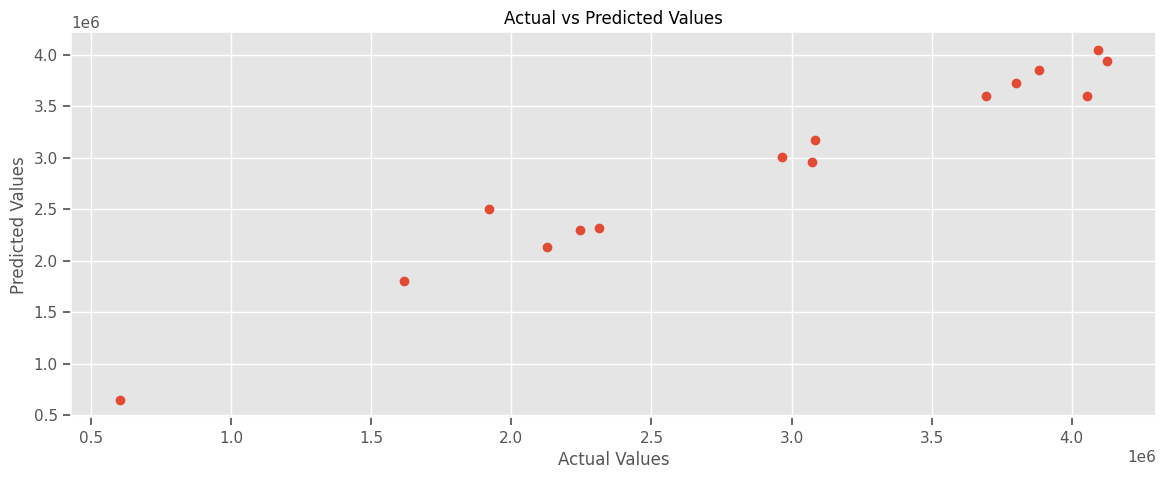

In [580]:
plt.scatter(y_test_v3, y_pred_v3)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


Not bad they resembe a diagnal line.

#### Random Forest results

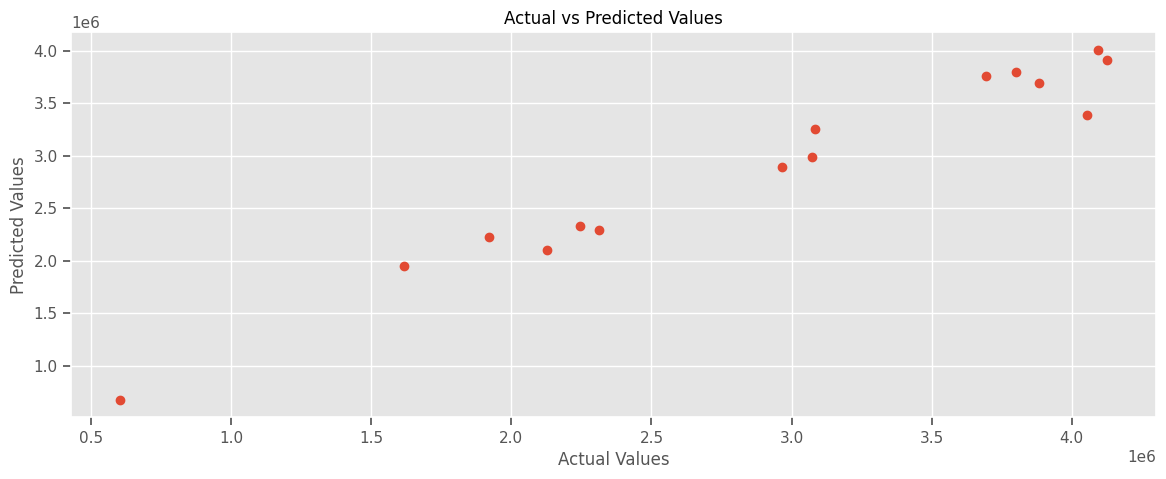

In [581]:
plt.scatter(y_test_v3, y_pred_rfr_v3)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

Same here not bad overall

Using EIA projections to forcast

## Modeling Natural Gas, Coal, and Oil

If we can model and forcast these three we can feed them back into our OLR, GradientBoostingRegressor, Random foresst models to forcast Total US energy production.

### Natural Gas

We will start with Natural gas as it has the highest correlation. We will use only from 2010 onward because, as we saw earlier in the EDA, that is when the types of energy the US produces change drastically.

In [582]:
nat_gas_prod = production_df['Natural Gas Plant Liquids Production']
nat_gas_prod = nat_gas_prod[~(nat_gas_prod.index % 100 == 13)]
nat_gas_prod.index = pd.to_datetime(nat_gas_prod.index, format='%Y%m')
nat_gas_prod = nat_gas_prod.astype(float)
nat_gas_prod = nat_gas_prod[nat_gas_prod.index >= '2000-01-01']
cutoff_nat_gas = round(nat_gas_prod.shape[0]*0.8)

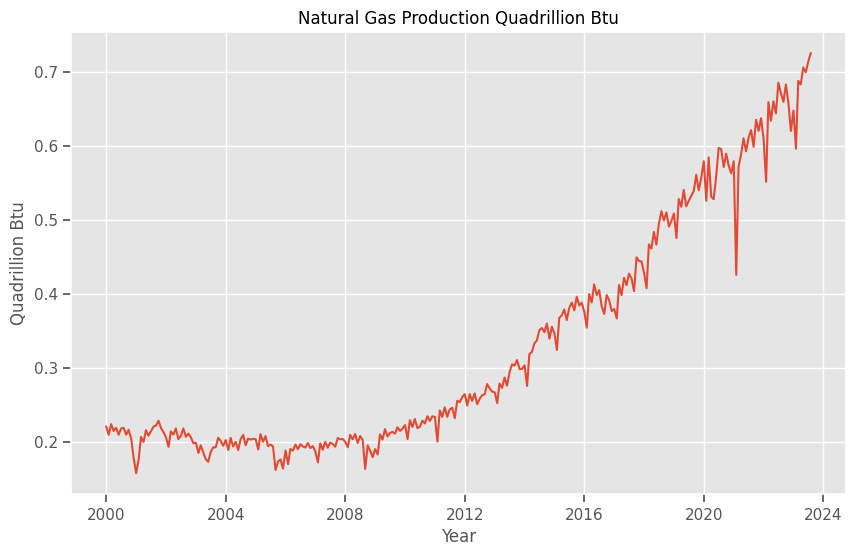

In [583]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=nat_gas_prod)
plt.title("Natural Gas Production Quadrillion Btu")
plt.xlabel('Year')
plt.ylabel('Quadrillion Btu')
plt.grid(True)
plt.show()

#### Train and split the data

This way we have data that the model has not seen to test the model.

In [584]:
train_nat_gas = nat_gas_prod[:(cutoff_nat_gas+1)]
test_nat_gas = nat_gas_prod[cutoff_nat_gas:]
test_nat_gas = test_nat_gas.astype(float)

Text(0, 0.5, 'Production Quadrillion Btu')

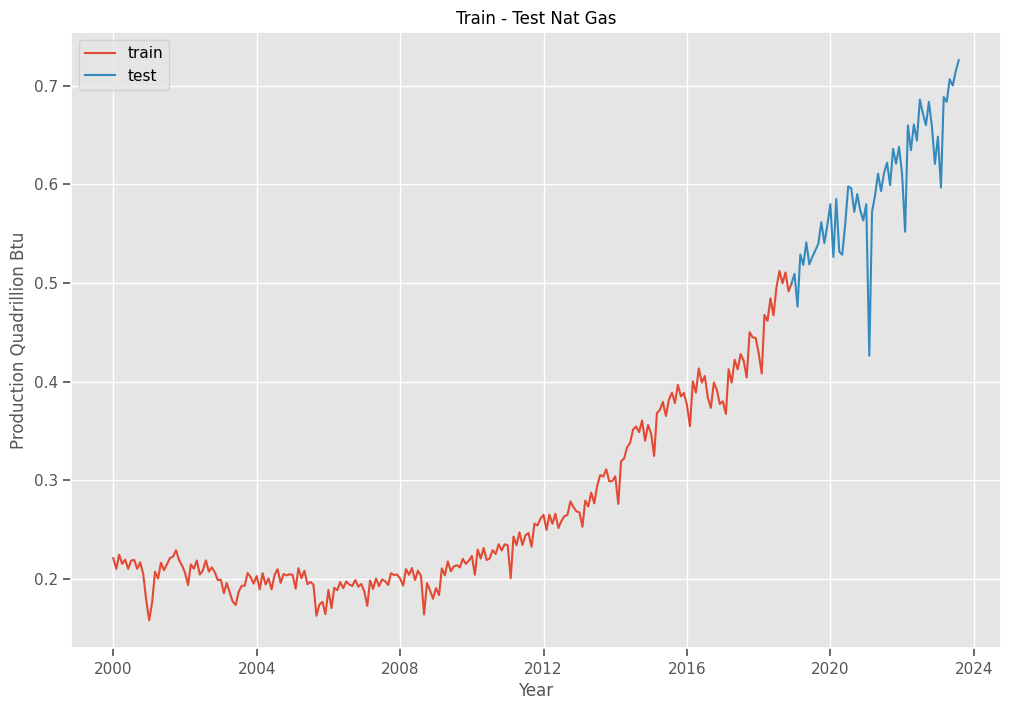

In [585]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_nat_gas, label='train')
ax.plot(test_nat_gas, label='test')
ax.set_title('Train - Test Nat Gas')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Production Quadrillion Btu")

#### Validation Set

We use TimeSeriesSplit to so we have data that kept separate in order to validate our models.

In [586]:
split = TimeSeriesSplit()
for train_ind, val_ind in split.split(train_nat_gas):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37] [38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75] [ 76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92

#### Stationarity

We are going to use ARMA models to try and forecast. We want our data to be free of trends and seasonality. We use a Dickey-Fuller test in order to see if there is a trend or stationarity, which is related to the consistency of mean, variance, and autocorrelation over time

In [587]:
dftest_nat_gas = adfuller(train_nat_gas)

dfoutput_nat_gas = pd.Series(dftest_nat_gas[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_nat_gas[4].items():
    dfoutput_nat_gas['Critical Value (%s)'%key] = value
print(dfoutput_nat_gas)

Test Statistic                   2.459815
p-value                          0.999036
#Lags Used                      15.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


Clearly not stationary the p-value is .98. We fail to reject our null hypothesis that the data is not stationary. In other words the data is clearly stationary. 

#### Series Decomposition

Using decomposition we can pull out the trend, and seasonality apart and display them. Leaving the residual which we will test next.

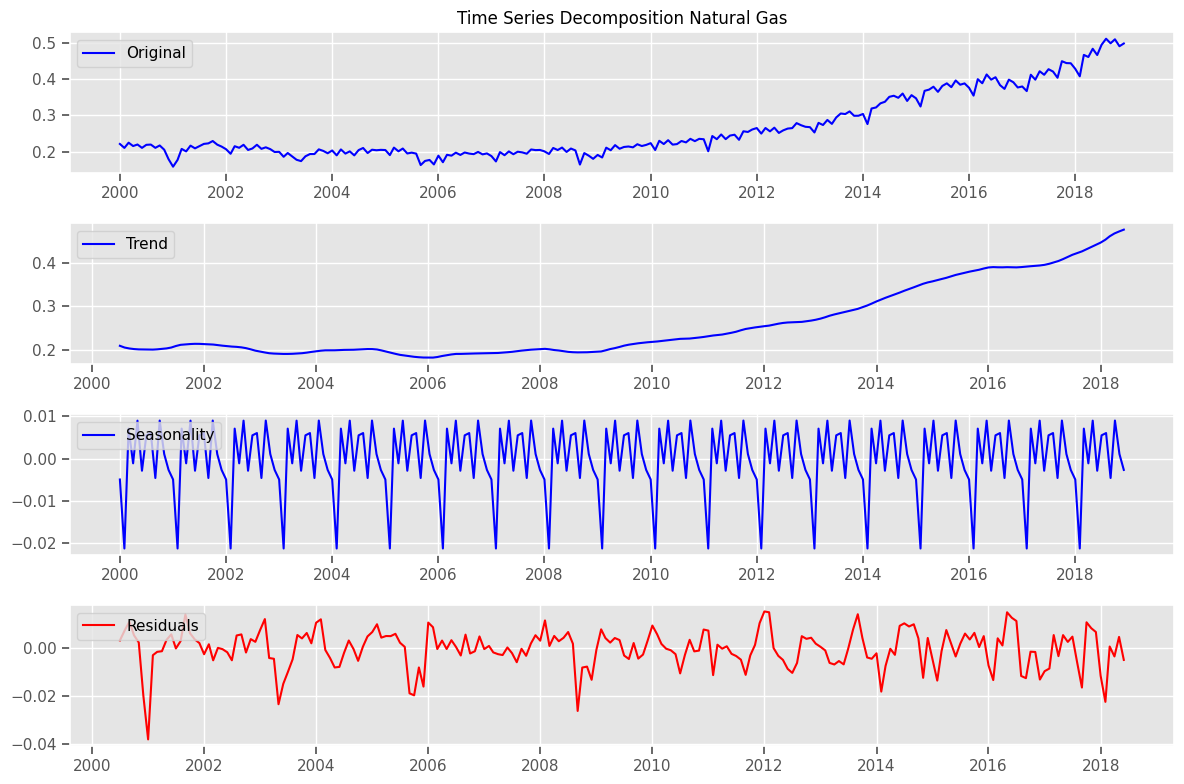

In [588]:
decomposition = seasonal_decompose(train_nat_gas)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Natural Gas')
plt.plot(train_nat_gas, label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='upper left')

plt.tight_layout();

This chart breaks out the trend, and seasonality from out data to show use what is left on the bottom.

In [589]:
residual.dropna(inplace=True)

In [590]:
dftest = adfuller(residual)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -8.438302e+00
p-value                        1.791607e-13
#Lags Used                     7.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00
Critical Value (5%)           -2.875538e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


The p-value is under .05 so we are now stationary. We just have to use the residual when training the models. 

#### Autocorrelation

Autocorrelation will reveal the stength and direction of linear relationships between observations. As pointed out in the EDA from above the production of energy is very seasonal.

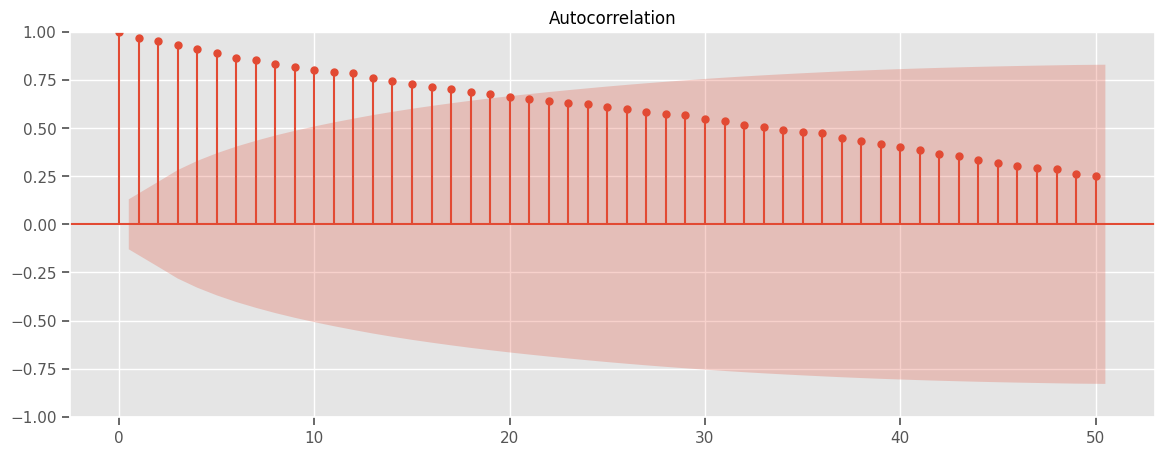

In [591]:
rcParams['figure.figsize'] = 14, 5

plot_acf(train_nat_gas, lags=50);

In [592]:
nat_diff = train_nat_gas.diff(periods=1)
nat_diff.dropna(inplace=True)

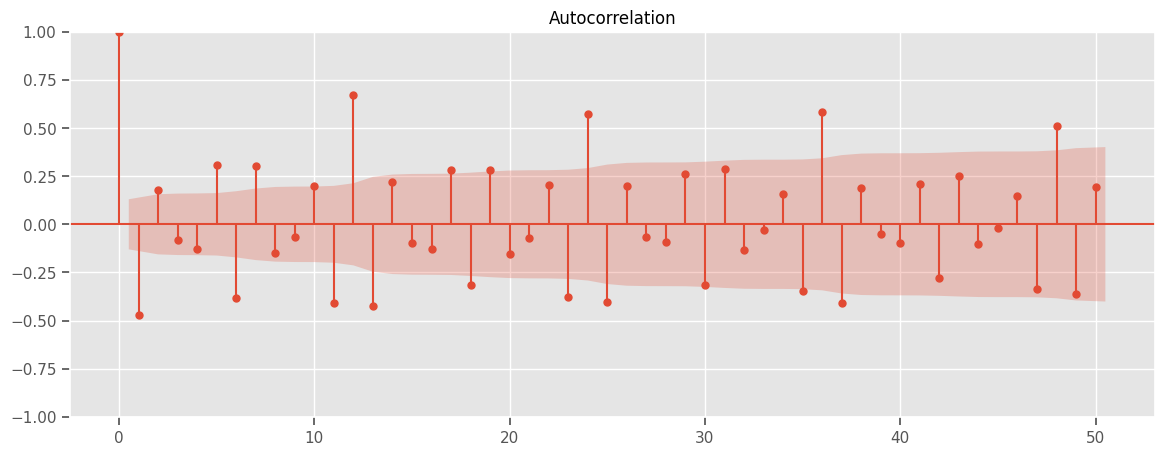

In [593]:
rcParams['figure.figsize'] = 14, 5
plot_acf(nat_diff, lags=50);

when we took out the first period we can now see lots of correlations with 12,24 and 36 months or 1,2, and  years.

#### Baseline Model

Make a native model so we can have a base line. All we have to do is shift the data by one period.

In [594]:
naive = train_nat_gas.shift(1)
naive

YYYYMM
2000-01-01         NaN
2000-02-01    0.221167
2000-03-01    0.210242
2000-04-01    0.224684
2000-05-01    0.215385
                ...   
2018-08-01    0.495565
2018-09-01    0.512256
2018-10-01    0.499684
2018-11-01    0.510705
2018-12-01    0.491540
Name: Natural Gas Plant Liquids Production, Length: 228, dtype: float64

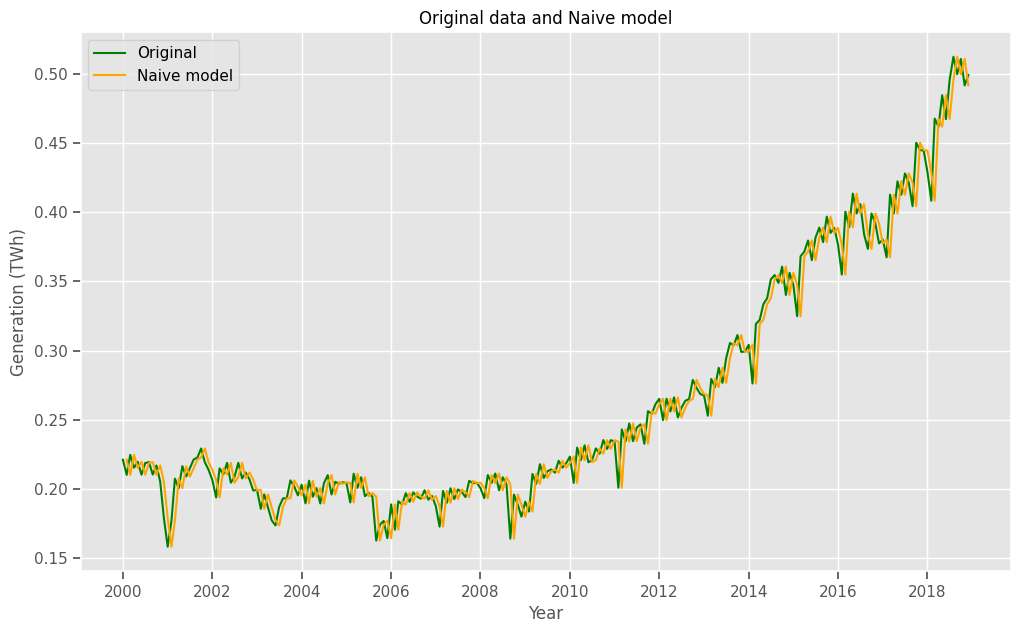

In [595]:
fig = plt.figure(figsize=(12,7))
plt.plot(train_nat_gas, color='green', label='Original')
plt.plot(naive, color='orange', label='Naive model')
plt.legend(loc='best')
plt.title('Original data and Naive model')
plt.xlabel("Year")
plt.ylabel("Generation (TWh)")
plt.show(block=False)

We will use Root Mean Squared Error to calculate the mean error between the value predicted and the real ones. The lower the better. 

In [596]:
RMSE_naiv=round(np.sqrt(mean_squared_error(train_nat_gas[1:], naive.dropna())),6)
print(f'The RMSE for the naive baseline model is in TWh: {RMSE_naiv}')

The RMSE for the naive baseline model is in TWh: 0.015087


In [597]:
RMSE_naiv = RMSE_naiv=round(np.sqrt(mean_squared_error(train_nat_gas[1:], naive.dropna())),6)
print(f'RMSE in Qu btu: {RMSE_naiv}')

RMSE in Qu btu: 0.015087


That is the number to beat. If we can not get lower than .015 then our model is not good enough. 

#### ARMA model


The ARMA (AutoRegressive Moving Average) model is a class of time series models that combines autoregressive (AR) and moving average (MA) components. p represents the order of the autoregressive (AR) component. d represents the number of times the series is differenced to achieve stationarity. q represents the order of the moving average (MA) component.

We can try some combinations of p,d,q and see what we get. We will look for AIC and RMSE to indicate how each combination is for our data. AIC is a measure of the goodness of fit of a statistical model. RMSE is a measure of the average magnitude of the errors between predicted and observed values.

In [598]:
aics=[]
rmses=[]

def find_rmse(model, train_data=train_nat_gas):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [599]:
mod_ar = ARIMA(train_nat_gas, order=(1,0,0))
res_ar = mod_ar.fit()
aics.append(['armd', res_ar.aic])
rmses.append(['armd',find_rmse(res_ar)] )


rw = ARIMA(train_nat_gas, order=(0,1,0))
res_rw = rw.fit()
aics.append(['rwlk', res_rw.aic])
rmses.append(['rwlk',find_rmse(res_rw)] )

mod_arfd = ARIMA(train_nat_gas, order=(1,1,0))
res_arfd = mod_arfd.fit()
aics.append(['arfd', res_arfd.aic])
rmses.append(['arfd',find_rmse(res_arfd)] )

mod_arma = ARIMA(train_nat_gas, order=(1,1,1))
res_arma = mod_arma.fit()
aics.append(['arma', res_arma.aic])
res_arma.aic
rmses.append(['arma',find_rmse(res_arma)] )

In [600]:
aics

[['armd', -1255.913480395604],
 ['rwlk', -1257.8468915808548],
 ['arfd', -1309.6847022553616],
 ['arma', -1307.9034398028114]]

In [601]:
rmses

[['armd', 0.016252661886272748],
 ['rwlk', 0.021003654707464986],
 ['arfd', 0.019829998966739985],
 ['arma', 0.01982567271464566]]

#### Grid search set up for ARIMA model

A grid search will help us seach for the besT parameters for our model quickly. This function uses some loops to try all combinations. 

In [602]:
def evaluate_models_aic(dataset, p_values, d_values, q_values):   
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(dataset, order=order)
                    model_fit = model.fit()
                    aic=model_fit.aic
                    if aic < best_score:
                        best_score, best_cfg = aic, order
                    print('ARIMA%s AIC=%.3f' % (order,aic))
                except:
                    continue
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score))

In [603]:
warnings.filterwarnings("ignore")

#### First grid search

This takes a while to run so i commented it out.

In [604]:
'''p_values = [0, 1, 2, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models_aic(train_nat_gas, p_values, d_values, q_values)'''

'p_values = [0, 1, 2, 4, 6, 8]\nd_values = range(0, 3)\nq_values = range(0, 3)\nwarnings.filterwarnings("ignore")\nevaluate_models_aic(train_nat_gas, p_values, d_values, q_values)'

The smaller the AIC the better so we will take ARIMA(4, 0, 2) that our grid searhch gave us.

In [605]:
model_1stgrd = ARIMA(train_nat_gas, order=(4,0,2)).fit()

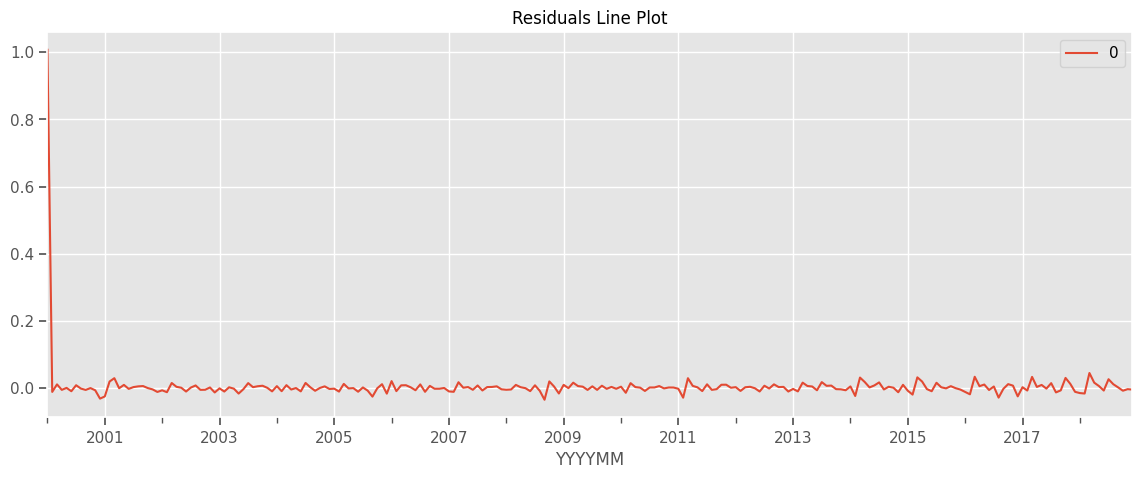

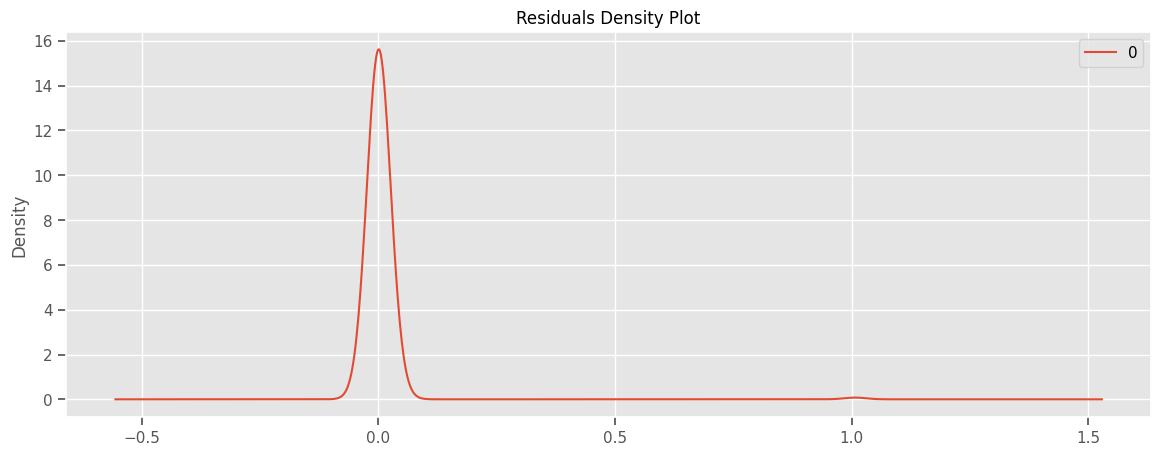

                0
count  228.000000
mean     0.005761
std      0.067642
min     -0.034220
25%     -0.005900
50%      0.001477
75%      0.007306
max      1.007458


In [606]:
# line plot of residuals
residuals = pd.DataFrame(model_1stgrd.resid)
residuals.plot()
plt.title('Residuals Line Plot')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.title('Residuals Density Plot')
plt.show()
# summary stats of residuals
print(residuals.describe())

Test the data after the parameter turning to make sure is normally distributed and there is no seasonality

In [607]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -6.476890e+00
p-value                        1.324319e-08
#Lags Used                     1.100000e+01
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


In [608]:
print(f'{round(find_rmse(model_1stgrd),4)}')

0.0677


A rmse of .067 is not better then our native model so we need to further adjust the parameters.

#### Second grid search

Again this is comented out as it take a while to run.

In [609]:
'''p_values = [8, 10, 12, 20]
d_values = [1, 2, 4]
q_values = [1, 2, 4]
warnings.filterwarnings("ignore")
evaluate_models_aic(train_nat_gas.values, p_values, d_values, q_values)'''

'p_values = [8, 10, 12, 20]\nd_values = [1, 2, 4]\nq_values = [1, 2, 4]\nwarnings.filterwarnings("ignore")\nevaluate_models_aic(train_nat_gas.values, p_values, d_values, q_values)'

The gid search put out 12,4,2 so lets try.

In [610]:
model_2ndgrd = ARIMA(train_nat_gas, order=(12,4,2)).fit()

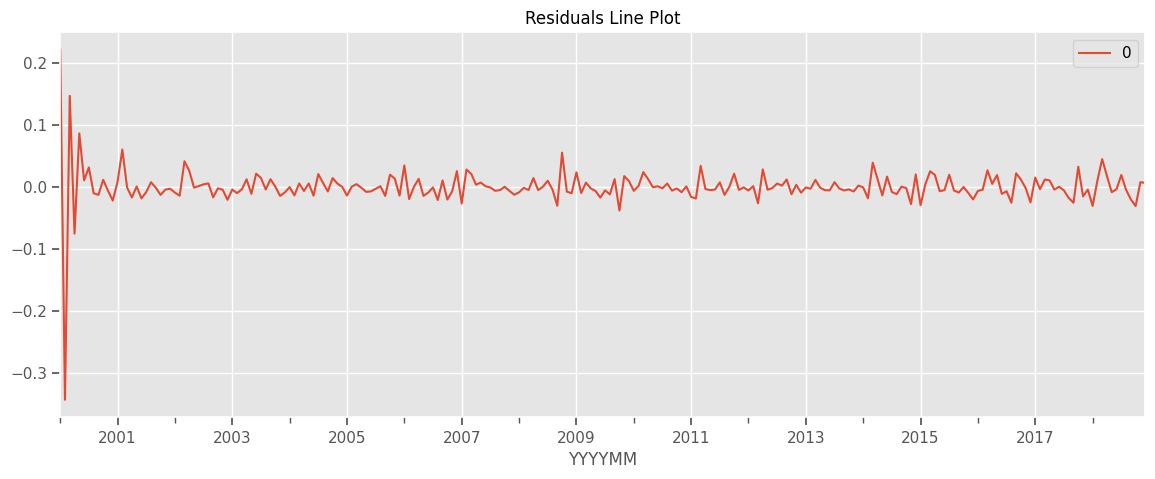

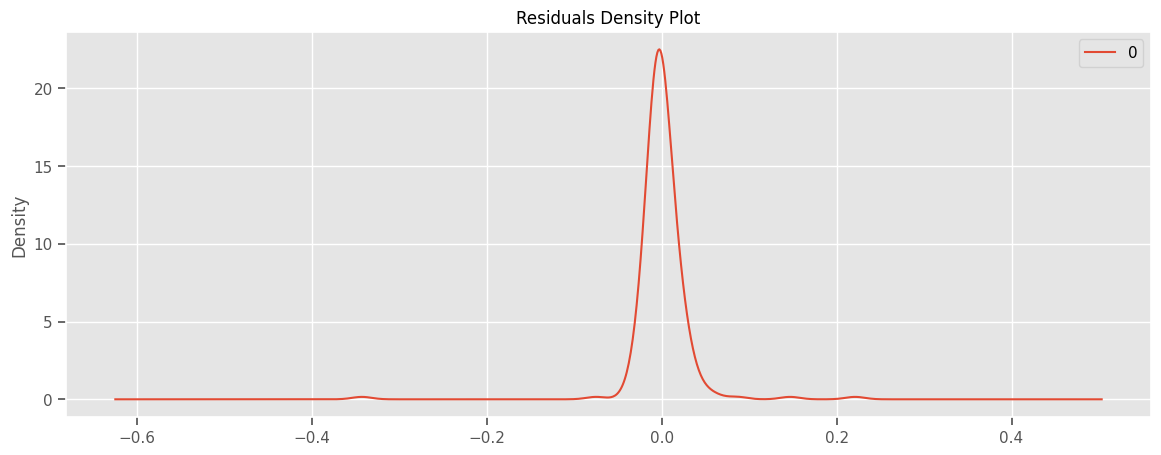

                0
count  228.000000
mean     0.000286
std      0.033382
min     -0.342676
25%     -0.008590
50%     -0.001999
75%      0.007990
max      0.221167


In [611]:
residuals = pd.DataFrame(model_2ndgrd.resid)
residuals.plot()
plt.title('Residuals Line Plot')
plt.show()

residuals.plot(kind='kde')
plt.title('Residuals Density Plot')
plt.show()

print(residuals.describe())

In [612]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -8.097214e+00
p-value                        1.329114e-12
#Lags Used                     1.500000e+01
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


In [613]:
print(f'The RMSE is {round(find_rmse(model_2ndgrd),6)}{Style.RESET_ALL} Qa Btu:')

The RMSE is 0.03331 Qa Btu:


Still not good enough to beat our native model. 

#### Cross Validation Second grid search

This is also not the result that we want. There is too much error here to make a good model. 

In [614]:
train_with_ind = train_nat_gas.reset_index()

In [615]:
cv=[]
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(8, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    cv.append(round(np.sqrt(mean_squared_error(true, preds)),2))
    print(np.sqrt(mean_squared_error(true, preds)))

0.012911526173312657


0.016421564622529288
0.04032709570403957
0.07449075490083781
0.056554906280361576


In [616]:
print(round(np.mean(cv),4))

0.04


In [617]:
residual.dropna(inplace=True)

In [618]:
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -8.438302e+00
p-value                        1.791607e-13
#Lags Used                     7.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00
Critical Value (5%)           -2.875538e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


### That didn't work

### Lets put our data to the test

I was able to get some data from EIA regarding annual projections out to 2050 for Coal, Natrual Gas, and oil projects. 

In [619]:
eia_pred = pd.read_csv('energy predictions.csv')

eia_pred = eia_pred[['YYYYMM', 'Oil', 'NGL', 'Coal']]
eia_pred.set_index(eia_pred['YYYYMM'],inplace = True)
eia_pred.drop(columns=['YYYYMM'], inplace=True)
eia_pred.rename(columns=dict(zip(eia_pred.columns, x_train_v3.columns)), inplace=True)
eia_pred.head()

,Crude Oil Production,Natural Gas Plant Liquids Production,Coal Production
YYYYMM,,,
2023,26.10187,12.187650,11.971200
2024,26.97913,12.431403,11.731776
2025,28.01115,12.680031,11.497140
2026,28.57522,12.933632,11.267198
2027,28.77881,13.192304,11.041854


#### Forcasting with OLR

In [620]:
new_data_with_constant = sm.add_constant(eia_pred)
predictions = ols_model.predict(new_data_with_constant)


In [621]:
eia_forcast_ols = pd.Series(predictions)
eia_forcast_ols.index = eia_pred.index
eia_forcast_ols = eia_forcast_ols.rename(index='YYYYMM')

In [622]:
eia_forcast_ols

YYYYMM
2023    8.110383e+06
2024    7.903350e+06
2025    7.689063e+06
2026    7.515292e+06
2027    7.373728e+06
2028    7.233421e+06
2029    7.114991e+06
2030    6.994142e+06
2031    6.881429e+06
2032    6.781739e+06
2033    6.666785e+06
2034    6.567670e+06
2035    6.495738e+06
2036    6.440390e+06
2037    6.375737e+06
2038    6.313192e+06
2039    6.248630e+06
2040    6.195181e+06
2041    6.136830e+06
2042    6.068963e+06
2043    5.982806e+06
2044    5.920558e+06
2045    5.889489e+06
2046    5.837450e+06
2047    5.785881e+06
2048    5.756380e+06
2049    5.730942e+06
2050    5.744654e+06
Name: YYYYMM, dtype: float64

Text(0, 0.5, 'Production Quadrillion Btu')

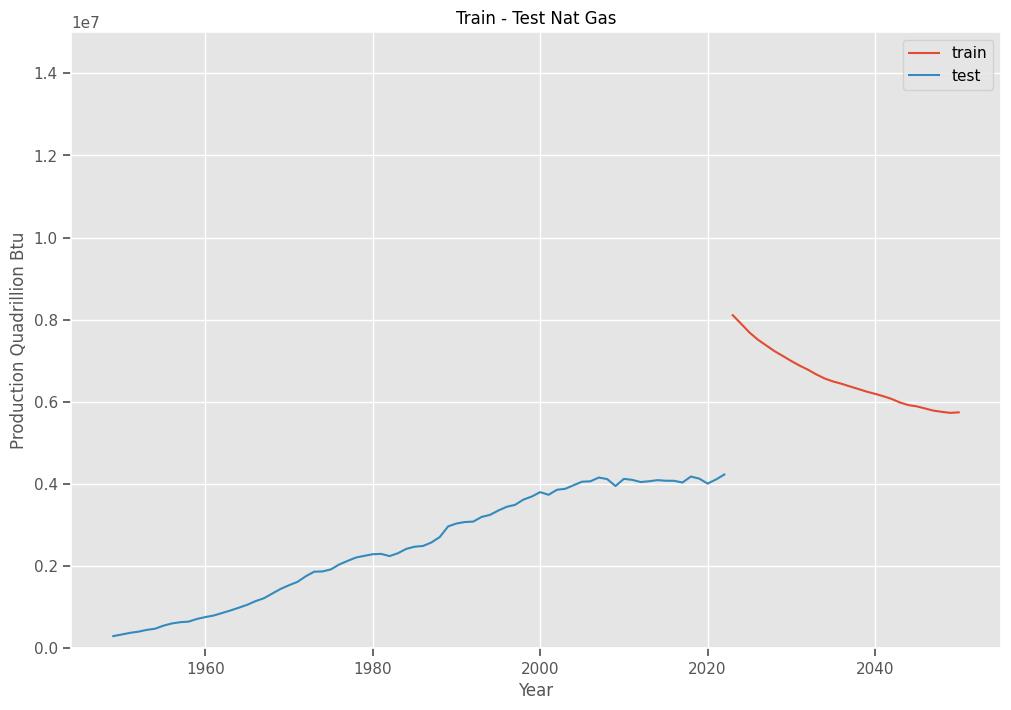

In [623]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(eia_forcast_ols, label='train')
ax.plot(y_df_gb_v3, label='test')
ax.set_title('Train - Test Nat Gas')
ax.set_ylim(0, 15000000)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Production Quadrillion Btu")

#### Forcasting with Gradient Boositing Regressor

In [624]:
net_gen_forcast = gbr_v3.predict(eia_pred)
print(net_gen_forcast)

[4207223.85592993 4191907.1049962  4191907.1049962  4191907.1049962
 4116488.97474796 4116488.97474796 4116488.97474796 4116488.97474796
 4116488.97474796 4116488.97474796 4116488.97474796 4116488.97474796
 4116488.97474796 4116488.97474796 4116488.97474796 4116488.97474796
 4116488.97474796 4116488.97474796 4116488.97474796 4116488.97474796
 4116488.97474796 4116488.97474796 4116488.97474796 4116488.97474796
 4116488.97474796 4116488.97474796 4116488.97474796 4116488.97474796]


In [625]:
eia_forcast_df = pd.Series(net_gen_forcast)
eia_forcast_df.index = eia_pred.index
eia_forcast_df = eia_forcast_df.rename(index='YYYYMM')

Plot with real past data to see the trend

Text(0, 0.5, 'Production Quadrillion Btu')

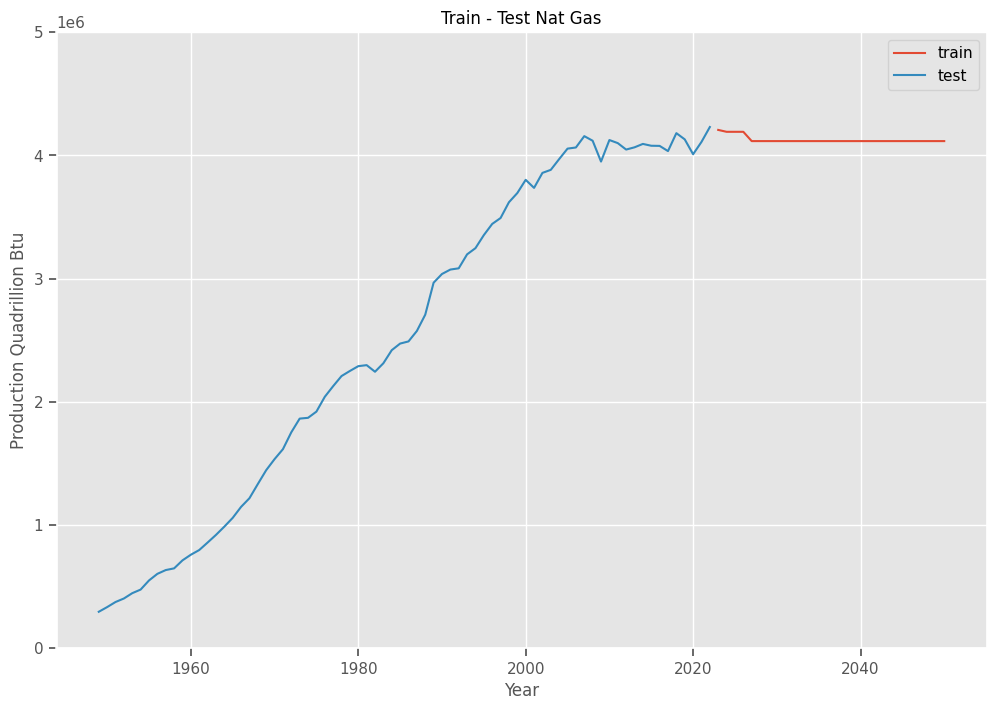

In [626]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(eia_forcast_df, label='train')
ax.plot(y_df_gb_v3, label='test')
ax.set_title('Train - Test Nat Gas')
ax.set_ylim(0, 5000000)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Production Quadrillion Btu")

#### Forcasting with Random Forest

In [627]:
eia_forcast_rf = rfr_v3.predict(eia_pred)
print(eia_forcast_rf)

[4078074.35432 4067188.45654 4067188.45654 4062770.3488  4039899.1781
 4039899.1781  4039899.1781  4039899.1781  4039899.1781  4039899.1781
 4039899.1781  4039899.1781  4039899.1781  4039899.1781  4039899.1781
 4039899.1781  4039899.1781  4039899.1781  4039899.1781  4039899.1781
 4039899.1781  4039899.1781  4039899.1781  4039899.1781  4039899.1781
 4039899.1781  4039899.1781  4039899.1781 ]


In [628]:
eia_forcast_rf = pd.Series(eia_forcast_rf)
eia_forcast_rf.index = eia_pred.index
eia_forcast_rf = eia_forcast_rf.rename(index='YYYYMM')

Text(0, 0.5, 'Production Quadrillion Btu')

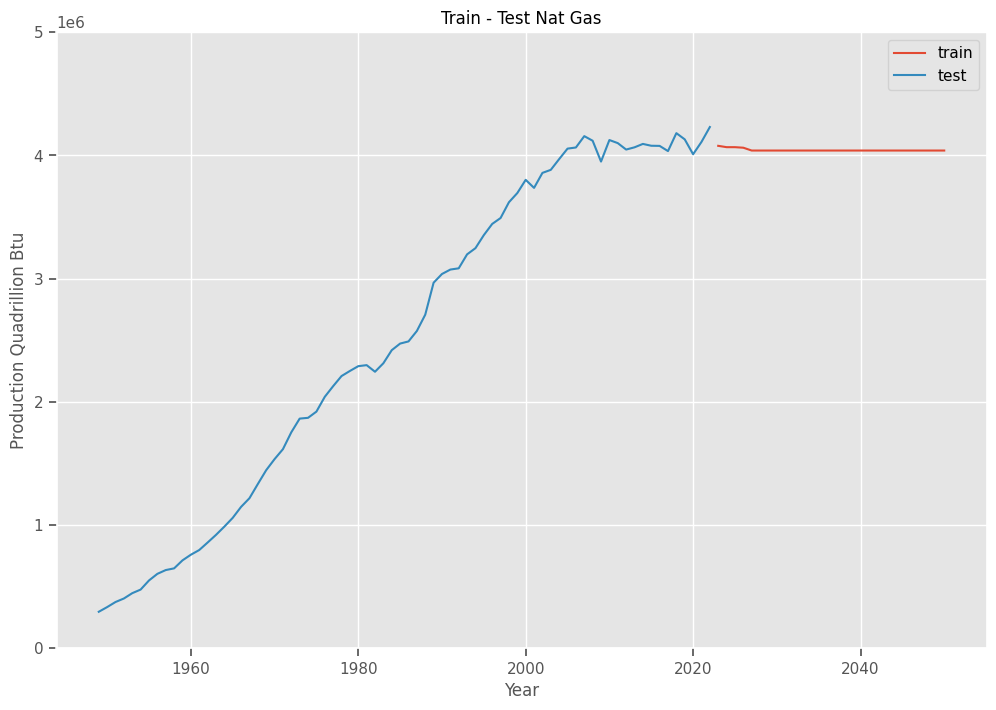

In [629]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(eia_forcast_rf, label='train')
ax.plot(y_df_gb_v3, label='test')
ax.set_title('Train - Test Nat Gas')
ax.set_ylim(0, 5000000)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Production Quadrillion Btu")

# Conclusion 

The models I developed did not yield the anticipated results, leaving me to question what went wrong. U.S. energy consumption is experiencing rapid growth year after year. The root of the problem lies in my choice of features to train the model. I opted for Natural, coal, and oil, given their historical significance as primary drivers of electricity production. Notably, Natural gas constitutes the largest proportion of energy types used for electrical generation. I also selected these features because they are not directly converted into electricity. For instance, solar, wind, and nuclear energy are inherently produced in the form of electricity.

This means that, in essence, I would be using parts of total electricity production to forecast itself—a scientific paradox. Despite these setbacks, the project wasn't an outright failure. The methodology for forecasting electricity generation exists; it's merely a matter of selecting more appropriately correlated features. In hindsight, I would choose features less directly related to energy, such as weather patterns impacting electrical draw from heating and cooling. I would also incorporate economic indicators and introduce a feature related to transportation, considering both the number of travelers over time and electric car sales to assess their impact.

Ultimately, the most significant takeaways from this project and my research on U.S. electricity production are the impressive and constant increase in renewable energy and the swift decline in coal as an energy source. I believe this topic is extremely important for planning infrastructure ahead of time, ensuring that when the demand arises, we have the means to move it effectively.